## Final Project - 311 Service Request Agency Predictions for 2024
## CS677 Machine Learning
## Spring 2025 / CRN 22928
## May 02, 2025
## Members: Joshua Gottlieb, Alex Yoo, Aryan Lagalwar, Jinhwi Lee

# Project Overview

In New York City, 311 is a non-emergency phone number for access to government services and information. https://portal.311.nyc.gov/about-nyc-311/

Unlike 911, 311 is not meant to report crimes and can be redirected to a number of agencies such as the Department of Parks and Recreation (DPR), Department of Transportation (DOT), Department of Environmental Protection (DEP), in addition to the typical emergency agencies such as the New York City Police Department (NYPD). Because the 311 service requests connect to so many different agencies, it is important for each request to be directed to the correct agency in order to resolve issues efficiently and effectively.

This project aims to use the 311 service data for the year of 2024 (01-01-2024 to 12-31-2024) to create a machine learning model that can automatically predict which agency a caller should be directed to when using the 311 service based off of some information about their request. This corresponds to a multiclass classification problem. Correct assignments to agencies is important to make sure requests are resolved properly and to prevent wasted time and resources by having to bounce a caller across multiple agencies. (https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data)

The 311 data for 2024 has over 3 million records to use, representing a robust dataset for machine learning.

# Imports

In [1]:
import pickle
import time

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from folium.plugins import MarkerCluster
from itertools import combinations
from scipy.stats import chi2_contingency
from shapely.geometry import Point

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support, precision_score, recall_score
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

/home/josh/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Step 1: Data Cleaning and Feature Engineering

In [2]:
# Load the data and inspect first few rows
df = pd.read_csv('data/311_Service_Requests_2024_to_2025.csv.bz2', low_memory = False)
df.head()

Unique Key            Created Date             Closed Date Agency  \
0    63573950  12/31/2024 11:59:38 PM  01/01/2025 12:26:35 AM   NYPD   
1    63574642  12/31/2024 11:59:33 PM  01/02/2025 05:08:17 PM   NYPD   
2    63581093  12/31/2024 11:59:32 PM  01/01/2025 12:18:51 AM   NYPD   
3    63574822  12/31/2024 11:59:31 PM  01/01/2025 09:01:36 AM   NYPD   
4    63580924  12/31/2024 11:59:21 PM  01/01/2025 12:42:47 AM   NYPD   

                       Agency Name       Complaint Type        Descriptor  \
0  New York City Police Department    Illegal Fireworks               NaN   
1  New York City Police Department  Noise - Residential  Loud Music/Party   
2  New York City Police Department  Noise - Residential  Loud Music/Party   
3  New York City Police Department  Noise - Residential  Loud Music/Party   
4  New York City Police Department  Noise - Residential  Loud Music/Party   

                Location Type Incident Zip         Incident Address  ...  \
0             Street/Sidewalk        11218                 AVENUE C  ...   
1  Residential Building/House        10466     655 EAST  230 STREET  ...   
2  Residential Building/House        11221  150 MALCOLM X BOULEVARD  ...   
3  Residential Building/House        10466     655 EAST  230 STREET  ...   
4  Residential Building/House        11230      1302 NEWKIRK AVENUE  ...   

  Vehicle Type Taxi Company Borough Taxi Pick Up Location Bridge Highway Name  \
0          NaN                  NaN                   NaN                 NaN   
1          NaN                  NaN                   NaN                 NaN   
2          NaN                  NaN                   NaN                 NaN   
3          NaN                  NaN                   NaN                 NaN   
4          NaN                  NaN                   NaN                 NaN   

  Bridge Highway Direction Road Ramp Bridge Highway Segment   Latitude  \
0                      NaN       NaN                    NaN  40.640915   
1                      NaN       NaN                    NaN  40.891872   
2                      NaN       NaN                    NaN  40.688335   
3                      NaN       NaN                    NaN  40.891872   
4                      NaN       NaN                    NaN  40.634745   

   Longitude                                  Location  
0 -73.973642  (40.640914779776715, -73.97364216306418)  
1 -73.860168   (40.89187241649303, -73.86016845296459)  
2 -73.930144  (40.688334599490894, -73.93014442097454)  
3 -73.860168   (40.89187241649303, -73.86016845296459)  
4 -73.964936    (40.6347449187686, -73.96493632865035)  

[5 rows x 41 columns]

In [3]:
# Inspect the available columns
df.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

### Feature Elimination

Many of the features are not particularly useful for modeling. For example, features such as Vehicle Type or Taxi Pick Up Location only apply to a small subset of the data. Others such as Addresses are too unique to meaningfully interpret or wrangle. Some like Descriptor are too similar to other columns that will be used like Complaint Type. In general, the purpose is to drop lots of features with low relevance or usability, especially if the functionality of that feature is already present in other columns.

In [4]:
# Drop columns with low relevance or usability
columns_to_drop = [
    'Unique Key', 'BBL', 'Location', 'Bridge Highway Name', 
    'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
    'Landmark', 'Facility Type', 'Status', 'Due Date', 'Agency',
    'Address Type', 'Resolution Description', 'Incident Address',
    'Street Name', 'Cross Street 1', 'Cross Street 2', 'Intersection Street 1',
    'Intersection Street 2', 'Resolution Action Updated Date', 'Community Board',
    'Park Facility Name', 'Park Borough', 'Vehicle Type', 'Taxi Company Borough',
    'Taxi Pick Up Location', 'Open Data Channel Type', 'X Coordinate (State Plane)',
    'Y Coordinate (State Plane)', 'Descriptor'
]

df = df.drop(columns_to_drop, axis = 1)

In [5]:
# Normalize remaining column names to snake case
df.columns = ['_'.join(column.split(' ')).lower() for column in df.columns]

In [6]:
# Inspect column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458311 entries, 0 to 3458310
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   created_date    object 
 1   closed_date     object 
 2   agency_name     object 
 3   complaint_type  object 
 4   location_type   object 
 5   incident_zip    object 
 6   city            object 
 7   borough         object 
 8   latitude        float64
 9   longitude       float64
dtypes: float64(2), object(8)
memory usage: 263.8+ MB


In [7]:
# Check missingness of columns
df.isnull().sum()

created_date           0
closed_date       107983
agency_name            0
complaint_type         0
location_type     416849
incident_zip       34384
city              161561
borough                0
latitude           53606
longitude          53606
dtype: int64

### Dealing with Time Columns

In [8]:
# Convert date columns to datetime types
df['created_date'] = pd.to_datetime(df['created_date'], format = "%m/%d/%Y %I:%M:%S %p")
df['closed_date'] = pd.to_datetime(df['closed_date'], format = "%m/%d/%Y %I:%M:%S %p")

# Replace NaT in closed date with last datetime of 2024
df['closed_date'] = df['closed_date'].fillna(pd.Timestamp("2024-12-31 23:59:59"))

# Truncate data to only include data where the incident occurred and resolved within 2024
df = df[(df['created_date'] >= '2024-01-01') & (df['created_date'] < '2025-01-01')]
df = df[(df['closed_date'] >= '2024-01-01') & (df['closed_date'] < '2025-01-01')]

In [9]:
# Create time of day category based on hour of incident
# Extract hour
hours = df['created_date'].dt.hour

# Define bins and labels
# 12AM-5:59AM = Night, 6AM-11:59AM = Morning, 12:00PM-5:59PM = Afternoon, 6:00PM-11:59PM = Night
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']

# Create a new column with time-of-day category
df['time_of_day'] = pd.cut(hours, bins = bins, labels = labels, right = False, include_lowest = True)

In [10]:
# Extract day of week and month from date of incident
df['day_of_week'] = df['created_date'].dt.day_name()
df['month'] = df['created_date'].dt.month_name()

# Extract hours passed until resolution and resolution status
# Event is assumed to be resolved if the closed date is not the maximum date in 2024
df['resolution_time_hours'] = ((df['closed_date'] - df['created_date']).dt.total_seconds()
                                   / 3600).round().astype(int)
df['resolved'] = df['closed_date'] != pd.Timestamp("2024-12-31 23:59:59")

In [11]:
# Drop original time columns, as they will no longer be used
df = df.drop(['created_date', 'closed_date'], axis = 1)

In [12]:
# Check if there are any negative resolution times
len(df[df['resolution_time_hours'] < 0])

767

In [13]:
# Only 767 records with negative resolution times (closed date < created date), so we will drop these records
df = df[df['resolution_time_hours'] >= 0]

In [14]:
# Check missingness of data again
df.isnull().sum()

agency_name                   0
complaint_type                0
location_type            400970
incident_zip              33675
city                     158496
borough                       0
latitude                  52730
longitude                 52730
time_of_day                   0
day_of_week                   0
month                         0
resolution_time_hours         0
resolved                      0
dtype: int64

### Check Target Variable (Agency Name)

In [15]:
# Only one instance of "3-1-1" and there are many categories with very few samples
df['agency_name'].value_counts()

agency_name
New York City Police Department                       1545766
Department of Housing Preservation and Development     710897
Department of Sanitation                               301513
Department of Transportation                           201862
Department of Environmental Protection                 189444
Department of Parks and Recreation                     126829
Department of Buildings                                 92369
Department of Health and Mental Hygiene                 68162
Department of Homeless Services                         51526
Taxi and Limousine Commission                           32598
Economic Development Corporation                        27491
Department of Consumer and Worker Protection            19326
Department of Education                                  1529
Office of Technology and Innovation                       154
3-1-1                                                       1
Name: count, dtype: int64

In [16]:
# Agencies which appear in low amounts of data will cause problems for modeling due to severe class imbalances
df['agency_name'].value_counts(normalize = True).round(4)

agency_name
New York City Police Department                       0.4588
Department of Housing Preservation and Development    0.2110
Department of Sanitation                              0.0895
Department of Transportation                          0.0599
Department of Environmental Protection                0.0562
Department of Parks and Recreation                    0.0376
Department of Buildings                               0.0274
Department of Health and Mental Hygiene               0.0202
Department of Homeless Services                       0.0153
Taxi and Limousine Commission                         0.0097
Economic Development Corporation                      0.0082
Department of Consumer and Worker Protection          0.0057
Department of Education                               0.0005
Office of Technology and Innovation                   0.0000
3-1-1                                                 0.0000
Name: proportion, dtype: float64

In [17]:
# We will wrap all of the agencies with less than 1% presence into a single "Other" category
df['agency_name'] = df['agency_name'].where(
    df['agency_name'].map(
        df['agency_name'].value_counts(normalize = True)
    ).gt(0.01), "Other"
)

In [18]:
# Checking agency name counts again - class imbalances are present but much improved
df['agency_name'].value_counts(normalize = True)

agency_name
New York City Police Department                       0.458757
Department of Housing Preservation and Development    0.210982
Department of Sanitation                              0.089484
Department of Transportation                          0.059909
Department of Environmental Protection                0.056224
Department of Parks and Recreation                    0.037641
Department of Buildings                               0.027414
Other                                                 0.024069
Department of Health and Mental Hygiene               0.020229
Department of Homeless Services                       0.015292
Name: proportion, dtype: float64

### Check Complaint Type

In [19]:
# There are many different complaint types, so it would be best to group these into categories of some sort
df['complaint_type'].unique()

array(['Noise - Commercial', 'Noise - Residential', 'Animal in a Park',
       'Rodent', 'Traffic Signal Condition', 'UNSANITARY CONDITION',
       'Noise - Park', 'Noise - Street/Sidewalk', 'Elevator', 'PLUMBING',
       'WATER LEAK', 'PAINT/PLASTER', 'Illegal Parking',
       'Non-Emergency Police Matter', 'Illegal Fireworks',
       'Noise - House of Worship', 'Blocked Driveway', 'Plumbing',
       'Taxi Complaint', 'Panhandling', 'Drug Activity',
       'Street Condition', 'Street Light Condition', 'Noise - Vehicle',
       'Water System', 'Drinking', 'For Hire Vehicle Report',
       'Root/Sewer/Sidewalk Condition', 'Encampment', 'Traffic',
       'Abandoned Vehicle', 'Noise', 'Animal-Abuse', 'Sewer',
       'Noise - Helicopter', 'Indoor Sewage', 'Bike/Roller/Skate Chronic',
       'Maintenance or Facility', 'ELECTRIC', 'APPLIANCE', 'DOOR/WINDOW',
       'GENERAL', 'Vendor Enforcement', 'Urinating in Public',
       'Unsanitary Animal Pvt Property', 'Real Time Enforcement',
      

In [20]:
# Creating a mapping for 12 different categories
# 1: Noise Complaints, 2: Animal-Relating Complaints, 3: Traffic & Parking
# 4: Building & Facility Complaints, 5: Public Safety & Legal Issues, 6. Environmental Complaints
# 7. Health & Food-Related, 8: Community Services & Outreach, 9: Other
# Note: Categories are not perfectly mapped, there may be some discrepancies
# as there were a lot of categories to manually assign

# Mapping dictionary
complaint_mapping = {
    'Noise Complaints': [
        'Noise - Commercial', 'Noise - Residential', 'Noise - Park', 'Noise - Street/Sidewalk',
        'Noise - Vehicle', 'Noise - House of Worship', 'Noise - Helicopter', 'Noise'
    ],
    'Animal-Related Complaints': [
        'Animal in a Park', 'Rodent', 'Animal-Abuse', 'Unsanitary Animal Pvt Property', 
        'Unleashed Dog', 'Dead Animal', 'Animal Facility - No Permit', 
        'Unsanitary Animal Facility', 'Illegal Animal Sold', 'Illegal Animal Kept as Pet',
        'Harboring Bees/Wasps', 'Pet Shop', 'Unsanitary Pigeon Condition', 'Illegal Tree Damage'
    ],
    'Traffic & Parking': [
        'Bike/Roller/Skate Chronic', 'Derelict Vehicles', 'For Hire Vehicle Complaint',
        'Bike Rack Condition', 'AHV Inspection Unit', 'Stalled Sites',
        'Traffic Signal Condition', 'Illegal Parking', 'Blocked Driveway',
        'Taxi Complaint', 'For Hire Vehicle Report', 'Abandoned Vehicle', 'Street Condition',
        'Street Light Condition', 'Traffic', 'Taxi Compliment', 'Broken Parking Meter',
        'Street Sweeping Complaint', 'Street Sign - Damaged', 'Street Sign - Dangling',
        'Street Sign - Missing', 'Bus Stop Shelter Placement', 'Bus Stop Shelter Complaint',
        'Municipal Parking Facility', 'Highway Condition', 'Highway Sign - Damaged',
        'Highway Sign - Dangling', 'Highway Sign - Missing', 'Taxi Report', 'Green Taxi Report',
        'Green Taxi Complaint', 'Taxi Licensee Complaint', 'Dispatched Taxi Complaint',
        'FHV Licensee Complaint', 'Abandoned Bike', 'E-Scooter', 'Bike Rack', 'Tunnel Condition'
    ],
    'Building & Facility Complaints': [
        'UNSANITARY CONDITION', 'Sewer', 'Dirty Condition', 'Wood Pile Remaining', 'Mold',
        'OUTSIDE BUILDING', 'Peeling Paint', 'Non-Residential Heat', 'Elevator', 'Plumbing',
        'WATER LEAK', 'Boilers', 'APPLIANCE', 'DOOR/WINDOW', 'FLOORING/STAIRS', 'HEAT/HOT WATER',
        'Building/Use', 'Outdoor Dining', 'Building Condition', 'Maintenance or Facility',
        'Indoor Air Quality', 'Building Drinking Water Tank', 'Construction Safety Enforcement',
        'School Maintenance', 'Cooling Tower', 'Electrical', 'ELECTRIC', 'Cranes and Derricks',
        'Scaffold Safety', 'General Construction/Plumbing', 'Construction Lead Dust', 'Snow or Ice',
        'ELEVATOR', 'PLUMBING', 'PAINT/PLASTER', 'Indoor Sewage'
    ],
    'Public Safety & Legal Issues': [
        'Real Time Enforcement', 'Investigations and Discipline (IAD)',
        'Emergency Response Team (ERT)', 'Sanitation Worker or Vehicle Complaint',
        'Special Projects Inspection Team (SPIT)', 'Ferry Complaint', 'Lifeguard',
        'Building Marshals office', 'X-Ray Machine/Equipment', 'Non-Emergency Police Matter',
        'Drug Activity', 'Panhandling', 'Illegal Fireworks', 'Violation of Park Rules',
        'Encampment', 'Obstruction', 'Disorderly Youth', 'Smoking', 'Squeegee',
        'Public Payphone Complaint', 'Illegal Posting', 'Posting Advertisement',
        'SAFETY', 'Urinating in Public', 'Vendor Enforcement', 'Retailer Complaint',
        'Tobacco or Non-Tobacco Sale', 'BEST/Site Safety', 'Transfer Station Complaint',
        'Illegal Dumping', "Building Marshal's Office"
    ],
    'Environmental Complaints': [
        'Root/Sewer/Sidewalk Condition', 'Damaged Tree', 'Dead/Dying Tree',
        'Overgrown Tree/Branches', 'Sidewalk Condition', 'Curb Condition',
        'New Tree Request', 'Uprooted Stump', 'Lead', 'Bridge Condition',
        'Recycling Basket Complaint', 'Special Natural Area District (SNAD)',
        'Lot Condition', 'Air Quality', 'Water Conservation', 'Hazardous Materials',
        'Radioactive Material', 'Asbestos', 'Oil or Gas Spill', 'Mosquitoes',
        'Plant', 'DEP Highway Condition', 'Water System', 'Standing Water',
        'DEP Street Condition', 'DEP Sidewalk Condition', 'Industrial Waste'
    ],
    'Health & Food-Related': [
        'Food Poisoning', 'Food Establishment', 'Drinking', 'Drinking Water', 
        'Consumer Complaint', 'Building Drinking Water Tank', 'Mobile Food Vendor',
        'Dumpster Complaint', 'Water Quality', 'Institution Disposal Complaint',
        'Residential Disposal Complaint', 'Commercial Disposal Complaint'
    ],
    'Community Services & Outreach': [
        'Litter Basket Request', 'Litter Basket Complaint', 'Adopt-A-Basket', 'Bench',
        'Wayfinding', 'Seasonal Collection', 'DSNY Internal', 'SNW', 'Homeless Person Assistance',
        'Lost Property', 'Found Property', 'Consumer Complaint', 'Borough Office',
        'Special Operations', 'Executive Inspections', 'Sustainability Enforcement',
        'Dept of Investigations', 'Public Toilet', 'LinkNYC', 'Ferry Inquiry', 'Beach/Pool/Sauna Complaint'
    ]
}

# Invert the dictionary for mapping
inverse_mapping = {}
for category, types in complaint_mapping.items():
    for complaint in types:
        inverse_mapping[complaint] = category

# Map the complaint_type to categories, mapping unspecified complaint types to "Other"
df['complaint_type'] = df['complaint_type'].map(inverse_mapping).fillna('Other')

In [21]:
# Checking the counts for the new categories, these categories are more reasonable
df['complaint_type'].value_counts(normalize = True)

complaint_type
Traffic & Parking                 0.299681
Building & Facility Complaints    0.261096
Noise Complaints                  0.222405
Public Safety & Legal Issues      0.071372
Environmental Complaints          0.068032
Other                             0.024810
Animal-Related Complaints         0.022663
Community Services & Outreach     0.021204
Health & Food-Related             0.008737
Name: proportion, dtype: float64

### Location Type

In [22]:
# There are missing values in this column
df['location_type'].isnull().sum()

np.int64(400970)

In [23]:
# Like with the complaint type, there are a lot of unique location types
# It would be helpful to put these into categories
df['location_type'].unique()

array(['Store/Commercial', 'Residential Building/House', 'Park',
       'Commercial Building', nan, 'Club/Bar/Restaurant',
       'RESIDENTIAL BUILDING', 'Park/Playground', 'Street/Sidewalk',
       'House of Worship', 'Street', 'Subway', 'Other', 'Hallway',
       'Lobby', 'Highway', 'Above Address', '1-2 Family Dwelling',
       'Common Area', '3+ Family Apartment Building',
       'Other (Explain Below)', '3+ Family Apt. Building', 'Sidewalk',
       'Bridge', '3+ Family Mixed Use Building', 'Taxi', 'Curb',
       'Restaurant/Bar/Deli/Bakery', 'Public/Unfenced Area',
       'Street/Curbside', 'Comercial', 'Yard', 'Alley', 'Public Garden',
       'Construction Site', 'Intersection', 'Gutter', 'Business',
       'Residence', 'Vacant Lot', 'House and Store', 'Food Cart Vendor',
       'Traffic Island or Median', 'Residential Building', 'Mixed Use',
       'Residential', 'Bus Stop Shelter', 'Kennel/Animal Shelter',
       '1-2 Family Mixed Use Building', 'Retail Store',
       'Mobile F

In [24]:
# Creating a mapping for 6 different categories
# 1: Street, 2: Residential, 3: Commercial,
# 4: Restaurant, 5: Outdoor, 6: Other
# Note: Categories are not perfectly mapped, there may be some discrepancies
# as there were a lot of categories to manually assign

# Mapping dictionary
location_mapping = {
    "Street": [
        'Street/Sidewalk', 'Street', 'Sidewalk', 'Highway', 'Intersection',
        'Alley', 'Curb', 'Street/Curbside', 'Taxi', 'Bus Stop Shelter',
        'Bike Lane', 'Vehicle Lane', 'Crosswalk', 'Speed Reducer',
        'Catch Basin/Sewer', 'Roadway Tunnel', 'Overpass', 'Public Stairs',
        'Street Area', 'Bridge', 'Gutter', 'Subway', 'Subway Station',
        'Street Fair Vendor'
    ],
    "Residential": [
        'Residential Building/House', 'RESIDENTIAL BUILDING', '1-2 Family Dwelling',
        '3+ Family Apartment Building', '3+ Family Apt. Building',
        '3+ Family Mixed Use Building', 'House and Store', 'Residence',
        'Residential Building', 'Residential', 'Private Residence',
        '1-3 Family Dwelling', '1-3 Family Mixed Use Building',
        '1-2 Family Mixed Use Building', 'Residential Property', 'Loft Residence',
        'Single Room Occupancy (SRO)', 'Nursing Home'
    ],
    "Commercial": [
        'Store/Commercial', 'Commercial Building', 'Comercial', 'Business',
        'Retail Store', 'Commercial', 'Commercial Property', 'Store',
        'Tire Shop', 'Groomer', 'Tanning Salon', 'Steam Room', 'Spa Pool',
        "Doctor's Office", 'Building (Non-Residential)', 'Office Building',
        'Medical Facility', 'Mixed Use Building', 'Sports Arena', 'Theater'
    ],
    "Restaurant": [
        'Club/Bar/Restaurant', 'Restaurant/Bar/Deli/Bakery', 'Food Cart Vendor',
        'Mobile Food Vendor', 'Food Establishment or Vendor', 'Restaurant',
        'Catering Service', 'Green Cart Vendor', 'Street Vendor',
        'Permanent Food Stand', 'Soup Kitchen', 'Cafeteria - Private',
        'Cafeteria - Private School', 'Cafeteria - Public School', 'Cafeteria - College/University'
    ],
    "Outdoor": [
        'Park', 'Park/Playground', 'Public/Unfenced Area', 'Yard',
        'Construction Site', 'Vacant Lot', 'Lot', 'Roof', 'Beach',
        'Ground', 'Pier', 'Wooded Area', 'Swamp or Pond', 'Horse Stable',
        'Petting Zoo/Animal Exhibit', 'Pool', 'Vacant Lot/Property', 'Parking Lot/Garage',
        'Parking Lot', 'Garage', 'Terminal', 'Ferry', 'Airport or Train/Bus Station',
        'Public Garden', 'Public Park/Garden', 'Public Garden/Park', 'Public Plaza',
        'Traffic Island or Median'
    ],
    "Other": [
        None, 'Other', 'House of Worship', 'Hallway', 'Lobby', 'Above Address',
        'Common Area', 'Other (Explain Below)', 'Kennel/Animal Shelter',
        'Inside', 'Vacant Building', 'Private Property', 'Abandoned Building',
        'Building Entrance', 'Building Condition', 'Building', 'Non-Profit',
        'Loft Building - Common Areas', 'Hospital', 'Cemetery', 'Senior Center',
        'Homeless Shelter', 'Sauna', 'Stairwell', 'Correctional Facility - City',
        'Correctional Facility - State', 'Mixed Use', 'Other (explain in Complaint Details)',
        'Government Building', 'School', 'School/Pre-School', 'Day Care/Nursery', 'School Safety Zone',
        'School - K-12 Public', 'School - K-12 Private', 'School - College/University'
    ]
}

# Invert the dictionary for mapping
inverse_mapping = {}
for category, types in location_mapping.items():
    for complaint in types:
        inverse_mapping[complaint] = category

# Map the location_type to categories, mapping unspecified complaint types to "Other"
df['location_type'] = df['location_type'].map(inverse_mapping).fillna('Other')

In [25]:
# Checking the counts for the new categories, these categories are more reasonable
df['location_type'].value_counts(normalize = True)

location_type
Street         0.463261
Residential    0.347715
Other          0.134256
Commercial     0.024554
Outdoor        0.018525
Restaurant     0.011690
Name: proportion, dtype: float64

### Location Data (City, Borough, Latitude/Longitude, and ZIP Code)

In [26]:
# There are a lot of values that need to be cleaned up, including null values
df['city'].unique()

array(['NEW YORK', 'STATEN ISLAND', 'BRONX', 'QUEENS', 'BROOKLYN',
       'OAKLAND GARDENS', nan, 'CORONA', 'JAMAICA', 'ASTORIA',
       'FOREST HILLS', 'FAR ROCKAWAY', 'ELMHURST', 'JACKSON HEIGHTS',
       'OZONE PARK', 'RIDGEWOOD', 'REGO PARK', 'COLLEGE POINT',
       'SOUTH RICHMOND HILL', 'EAST ELMHURST', 'MANHATTAN', 'WOODHAVEN',
       'SOUTH OZONE PARK', 'MASPETH', 'WOODSIDE', 'FLUSHING',
       'LITTLE NECK', 'SPRINGFIELD GARDENS', 'KEW GARDENS', 'WHITESTONE',
       'MIDDLE VILLAGE', 'BELLEROSE', 'FLORAL PARK', 'LONG ISLAND CITY',
       'ROSEDALE', 'FRESH MEADOWS', 'BAYSIDE', 'QUEENS VILLAGE',
       'HOWARD BEACH', 'SAINT ALBANS', 'SUNNYSIDE', 'RICHMOND HILL',
       'HOLLIS', 'ARVERNE', 'CAMBRIA HEIGHTS', 'GLEN OAKS',
       'NEW HYDE PARK', 'Nesconset', 'bronx', 'Staten Island', 'KATY',
       'Elmhurst', 'Manhattan', 'brooklyn', 'BREEZY POINT', 'Bentonville',
       'Brooklyn', 'New York', 'LAGUARDIA AIRPORT', 'Yonkers',
       'West Hempstead', 'La Grange', 'hicksville',

In [27]:
# Some of these locations are not in NYC, so let's preserve only locations in NYC and unknowns
nyc_areas = [
    'arverne', 'astoria', 'bayside', 'bellerose', 'breezy point', 'bronx',
    'brooklyn', 'cambria heights', 'college point', 'corona', 'east elmhurst',
    'elmhurst', 'far rockaway', 'flushing', 'forest hills', 'fresh meadows',
    'glen oaks', 'glendale queens', 'hollis', 'howard beach', 'jackson heights',
    'jamaica', 'jamaica queens', 'kew gardens', 'laguardia airport',
    'little neck', 'long island city', 'manhattan', 'maspeth', 'middle village',
    'new york', 'oakland gardens', 'ozone park', 'queens', 'queens village',
    'rego park', 'ridgewood', 'richmond hill', 'rosedale', 'saint albans',
    'south ozone park', 'south richmond hill', 'springfield boulevard',
    'springfield gardens', 'staten island', 'sunnyside', 'woodhaven', 'woodside',
    'whitestone', 'unknown'
]

# Convert city names to lowercase to normalize
df['city'] = df['city'].str.lower()

# Print number of dropped rows
print(f'Number of dropped rows: {len(df[(~df["city"].isin(nyc_areas)) & (df["city"].notna())])}')

# Drop all non-null rows outside of NYC
df = df[(df['city'].isin(nyc_areas)) | (df['city'].isna())]

Number of dropped rows: 1613


In [28]:
# The easiest way to impute the city is to use the borough name
# Checking that there are no rows where the city and borough are both null
df[(df['city'].isna()) & (df['borough'].isna())]

Empty DataFrame
Columns: [agency_name, complaint_type, location_type, incident_zip, city, borough, latitude, longitude, time_of_day, day_of_week, month, resolution_time_hours, resolved]
Index: []

In [29]:
# Impute missing values with borough names
df['city'] = df['city'].fillna(df['borough'].str.lower())

In [30]:
# Very few of the cities are prevalent enough to be worth using
# The most common "cities" are just borough names
df['city'].value_counts(normalize = True)[df['city'].value_counts(normalize = True).gt(0.01)].round(4)

city
brooklyn         0.3025
bronx            0.2141
new york         0.1895
staten island    0.0351
queens           0.0253
jamaica          0.0233
manhattan        0.0188
astoria          0.0170
flushing         0.0148
ridgewood        0.0115
Name: proportion, dtype: float64

In [31]:
# Even the "new york" designation is equivalent to Manhattan
df[df['city'] == 'new york'].borough.value_counts()

borough
MANHATTAN      638335
Unspecified        32
Name: count, dtype: int64

In [32]:
# Since the city is no longer useful, drop the city column
df = df.drop(['city'], axis = 1)

In [33]:
# Check the unique borough names, no null values
df['borough'].unique()

array(['MANHATTAN', 'STATEN ISLAND', 'BRONX', 'QUEENS', 'BROOKLYN',
       'Unspecified'], dtype=object)

In [34]:
# Check how many records have "Unspecified" as the borough
len(df[df['borough'] == 'Unspecified'])

2227

In [35]:
# Only ~2000 records out of more than 3 million, we will drop these records
df = df[df['borough'] != 'Unspecified']

In [36]:
# There are a number of missing zip codes
df.incident_zip.isna().sum()

np.int64(31684)

In [37]:
# There are a lot of ZIP codes, let's check to make sure each are in NYC
df['incident_zip'].unique()

array(['10031', '10013', '10314', '10456', '10128', '11421', '10004',
       '10472', '11208', '11364', '10025', '10457', '11236', '11435',
       '11368', '11432', '11106', '10467', '11375', '10305', '11694',
       '11223', '10016', '11207', '11373', '11224', '11230', '11204',
       '11210', '11239', '10012', '11233', '11372', '11219', '11417',
       '11232', '11220', '11385', '10466', '10462', '10454', '11237',
       '11374', '10453', '10040', '11356', '10465', '10312', '11238',
       '11221', '11691', '10033', '10022', '10038', '11419', '10452',
       '10461', '11369', '10028', '10029', '11214', '11206', '10027',
       '11226', '10302', '11215', '10034', nan, '10455', '10030', '10007',
       '11235', '11358', '11201', '10009', '10001', '11420', '10039',
       '11212', '11378', '11377', '10003', '10459', '11216', '11355',
       '10019', '11222', '10463', '10024', '10002', '10304', '11211',
       '11370', '11365', '10451', '10310', '11218', '11234', '11205',
       '11362',

In [38]:
# ZIP codes from Zillow: https://www.zillow.com/browse/homes/ny/new-york-county/
nyc_zip = [
    "10001", "10002", "10003", "10004", "10005", "10006", "10007", "10008", "10009",
    "10010", "10011", "10012", "10013", "10014", "10015", "10016", "10017", "10018",
    "10019", "10020", "10021", "10022", "10023", "10024", "10025", "10026", "10027",
    "10028", "10029", "10030", "10031", "10032", "10033", "10034", "10035", "10036",
    "10037", "10038", "10039", "10040", "10041", "10043", "10044", "10045", "10046",
    "10047", "10048", "10049", "10050", "10051", "10052", "10053", "10054", "10055",
    "10056", "10057", "10058", "10059", "10060", "10061", "10062", "10063", "10064",
    "10065", "10066", "10067", "10068", "10069", "10070", "10071", "10072", "10073",
    "10074", "10075", "10076", "10077", "10078", "10079", "10080", "10081", "10082",
    "10083", "10084", "10085", "10086", "10087", "10088", "10089", "10090", "10091",
    "10092", "10093", "10094", "10095", "10096", "10097", "10098", "10099", "10101",
    "10102", "10103", "10104", "10105", "10106", "10107", "10108", "10109", "10110",
    "10111", "10112", "10113", "10114", "10115", "10116", "10117", "10118", "10119",
    "10120", "10121", "10122", "10123", "10124", "10125", "10126", "10127", "10128",
    "10129", "10130", "10131", "10132", "10133", "10134", "10135", "10136", "10137",
    "10138", "10139", "10140", "10141", "10142", "10143", "10144", "10145", "10146",
    "10147", "10148", "10149", "10150", "10151", "10152", "10153", "10154", "10155",
    "10156", "10157", "10158", "10159", "10160", "10161", "10162", "10163", "10164",
    "10165", "10166", "10167", "10168", "10169", "10170", "10171", "10172", "10173",
    "10174", "10175", "10176", "10177", "10178", "10179", "10180", "10181", "10182",
    "10183", "10184", "10185", "10186", "10187", "10188", "10189", "10190", "10191",
    "10192", "10193", "10194", "10195", "10196", "10197", "10198", "10199", "10201",
    "10202", "10203", "10204", "10205", "10206", "10207", "10208", "10209", "10210",
    "10211", "10212", "10213", "10214", "10215", "10216", "10217", "10218", "10219",
    "10220", "10221", "10222", "10223", "10224", "10225", "10226", "10227", "10228",
    "10229", "10230", "10231", "10232", "10233", "10234", "10235", "10236", "10237",
    "10238", "10239", "10240", "10241", "10242", "10243", "10244", "10245", "10246",
    "10247", "10248", "10249", "10250", "10251", "10252", "10253", "10254", "10255",
    "10256", "10257", "10258", "10259", "10260", "10261", "10262", "10263", "10264",
    "10265", "10266", "10267", "10268", "10269", "10270", "10271", "10272", "10273",
    "10274", "10275", "10276", "10277", "10278", "10279", "10280", "10281", "10282",
    "10283", "10284", "10285", "10286"
]

# Convert values in the column to None if not in the nyc_zip list
df['incident_zip'] = df['incident_zip'].apply(lambda x: x if x in nyc_zip else None)

In [39]:
# Want to impute missing ZIP codes using latitude and longitude
# Using GeoPandas and ZCTA shapefile from US Census: https://www2.census.gov/geo/tiger/TIGER2023/ZCTA520/
# Create Point geometry column
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis = 1)
gdf_points = gpd.GeoDataFrame(df, geometry = 'geometry', crs = 'EPSG:4326')

# Load the ZCTA shapefile
zcta = gpd.read_file('data/tl_2023_us_zcta520.shp')
zcta = zcta.to_crs('EPSG:4326')  # Ensure same coordinate system

# Spatial join: assign ZIP code to each point
gdf_joined = gpd.sjoin(gdf_points, zcta[['ZCTA5CE20', 'geometry']], how = 'left', predicate = 'within')

# Fill missing ZIP codes only
df['incident_zip'] = df['incident_zip'].fillna(gdf_joined['ZCTA5CE20'])

In [40]:
# For the remaining missing ZIP codes, impute using the mode from each borough (as borough is non-missing)
# Compute mode ZIP for each borough
mode_zip = df.dropna(subset = ['incident_zip']).groupby('borough')['incident_zip'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)

# Create a mask for missing ZIPs
missing_mask = df['incident_zip'].isna()

# Fill missing ZIPs based on borough
df.loc[missing_mask, 'incident_zip'] = df.loc[missing_mask, 'borough'].map(mode_zip)

In [41]:
# Impute missing latitude and longitude values using the modes from the now non-missing ZIP column
# Calculate mode latitue/longitude per ZIP
lat_mode = df.dropna(subset = ['latitude']).groupby('incident_zip')['latitude'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)
lon_mode = df.dropna(subset = ['longitude']).groupby('incident_zip')['longitude'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)

# Create masks for missing latitude/longitude
lat_missing = df['latitude'].isna()
lon_missing = df['longitude'].isna()

# Fill missing values using the ZIP mode mappings
df.loc[lat_missing, 'latitude'] = df.loc[lat_missing, 'incident_zip'].map(lat_mode)
df.loc[lon_missing, 'longitude'] = df.loc[lon_missing, 'incident_zip'].map(lon_mode)

# Drop geometry column
df = df.drop(['geometry'], axis = 1)

### Final Checks in Preparation for EDA

In [42]:
# Check for missing values - should be none left
df.isnull().sum()

agency_name              0
complaint_type           0
location_type            0
incident_zip             0
borough                  0
latitude                 0
longitude                0
time_of_day              0
day_of_week              0
month                    0
resolution_time_hours    0
resolved                 0
dtype: int64

In [43]:
# Check data types, they seem appropriate
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3365627 entries, 64 to 3458310
Data columns (total 12 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   agency_name            object  
 1   complaint_type         object  
 2   location_type          object  
 3   incident_zip           object  
 4   borough                object  
 5   latitude               float64 
 6   longitude              float64 
 7   time_of_day            category
 8   day_of_week            object  
 9   month                  object  
 10  resolution_time_hours  int64   
 11  resolved               bool    
dtypes: bool(1), category(1), float64(2), int64(1), object(7)
memory usage: 288.9+ MB


# Step 2: Exploratory Data Analysis

In [44]:
# Define agency acronyms for more concise names while plotting
agency_mapping = {
    "New York City Police Department": "NYPD",
    "Department of Housing Preservation and Development": "HPD",
    "Department of Sanitation": "DSNY",
    "Department of Transportation": "DOT",
    "Department of Environmental Protection": "DEP",
    "Department of Parks and Recreation": "DPR",
    "Department of Buildings": "DOB",
    "Other": "Other",
    "Department of Health and Mental Hygiene": "DOHMH",
    "Department of Homeless Services": "DHS"
}


# Add a column mapping the acronyms to the original names
df["agency_acronym"] = df["agency_name"].map(agency_mapping)

### Helper Functions

In [45]:
# Helper function to configure fontsizes for a Matplotlib axis
def format_axis(axis, title, xlabel, ylabel):
    axis.set_title(title, fontsize = 20)
    axis.set_xlabel(xlabel, fontsize = 16)
    axis.set_ylabel(ylabel, fontsize = 16)
    axis.tick_params(axis = 'both', labelsize = 12)

    return

In [46]:
# Helper function add bar labels to a Matplotlib axis
def add_bar_labels(axis, fmt = '{:.2f}', fontsize = 12, color = 'black', offset = 5):
    for p in axis.patches:
        height = p.get_height()
        axis.annotate(fmt.format(height),
                      (p.get_x() + p.get_width() / 2., height),
                      ha = 'center', va = 'center',
                      fontsize = fontsize, color = color,
                      xytext = (0, offset), textcoords = 'offset points')
    return

In [47]:
# Helper function to save plots to PNG files
def save_figure_to_png(fig, filename, dpi = 300):
    # Apply tight layout to the figure
    fig.tight_layout()

    # Save the figure to the specified file with high DPI
    fig.savefig(filename, format = 'png', dpi = dpi)

    print(f"Figure saved as {filename} with {dpi} DPI.")

    return

### Raw Counts and Categorical Counts by Agency

The first thing to check is the raw counts of complaints by agency. The majority of complaints are directed towards the NYPD, followed by the Department of Housing Preservation and Development, then the Department of Sanitation and the Department of Transportation. The number of complaints trails off for the rest of the agencies. This indicates a large class imbalance that we will have to be aware of when modeling.

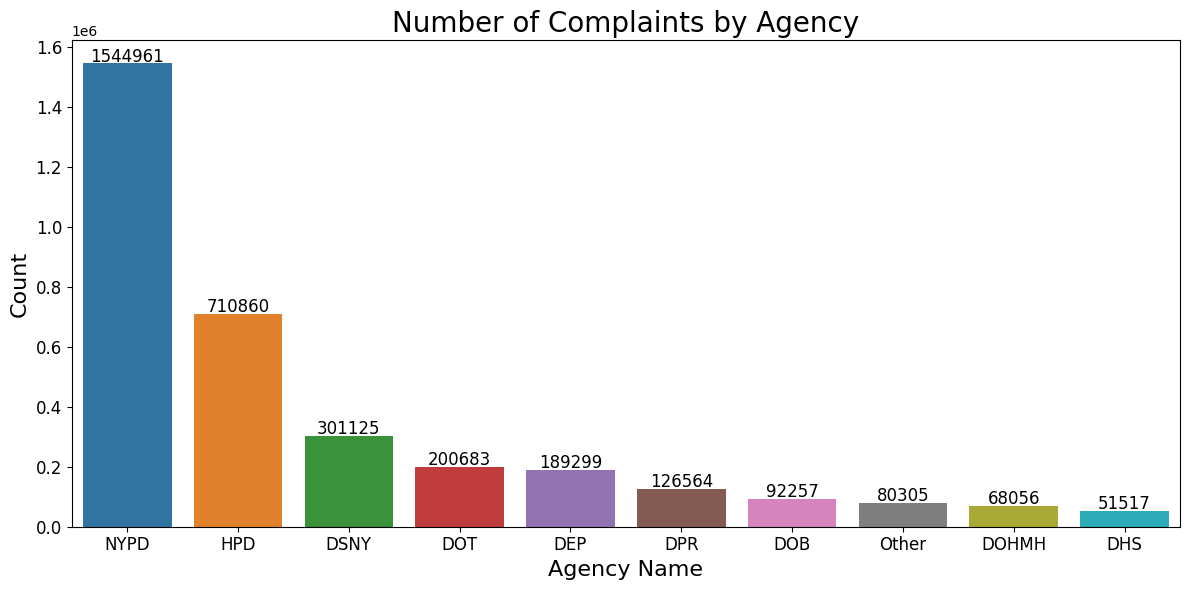

Figure saved as visualizations/complaints_by_agency.png with 300 DPI.


In [49]:
# Count of complaints per agency
agency_counts = df['agency_acronym'].value_counts()

# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = agency_counts.index, y = agency_counts.values, hue = agency_counts.index,
            palette = 'tab10', ax = ax)

# Add annotations
add_bar_labels(ax, fmt = '{:.0f}')

# Format plot
format_axis(ax, 'Number of Complaints by Agency', 'Agency Name', 'Count')

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/complaints_by_agency.png')

Looking at the complaint types that are distributed to agencies, noise, traffic complaints, and public safety complaints primarily go to the NYPD, while building complaints often go to the Department of Housing Preservation and Development. Many of the complaint types have clear agencies that take care of them, indicating good separability along this feature.

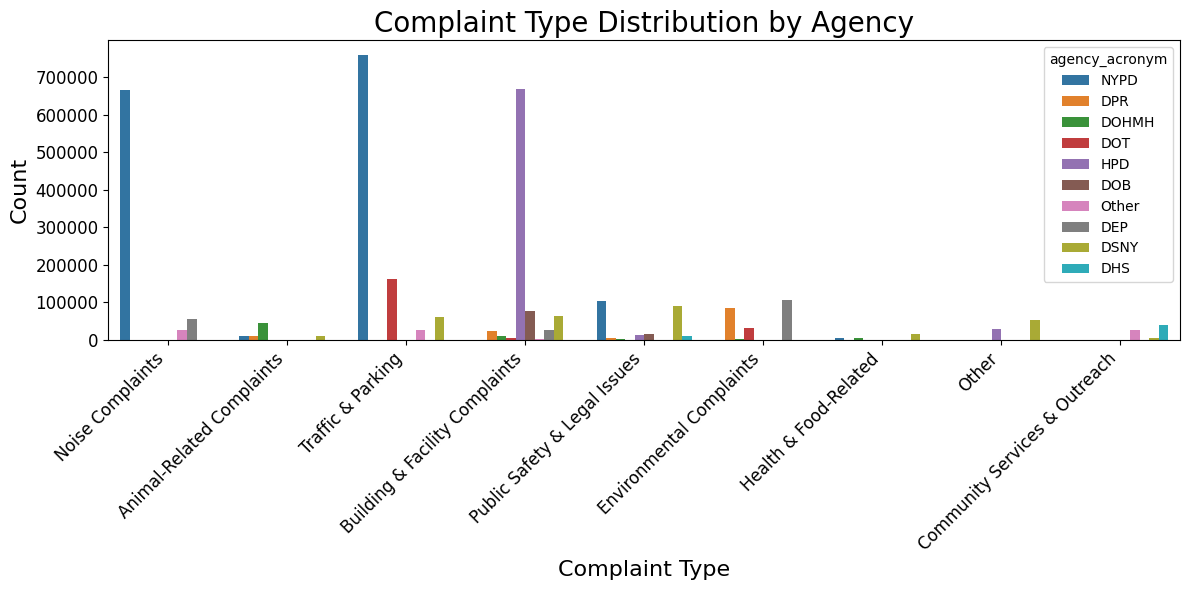

Figure saved as visualizations/complaint_type_by_agency.png with 300 DPI.


In [50]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'complaint_type', hue = 'agency_acronym', ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Complaint Type Distribution by Agency', 'Complaint Type', 'Count')

# Rotate x-ticks for better readability
plt.xticks(rotation = 45, ha = 'right')

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/complaint_type_by_agency.png')

The location type distribution by agency shows that most of the complaints that happen on the Street go to the NYPD, and most of the Residential complaints are split among the NYPD and the HPD. The other location types are not so obvious in terms of separation of agency.

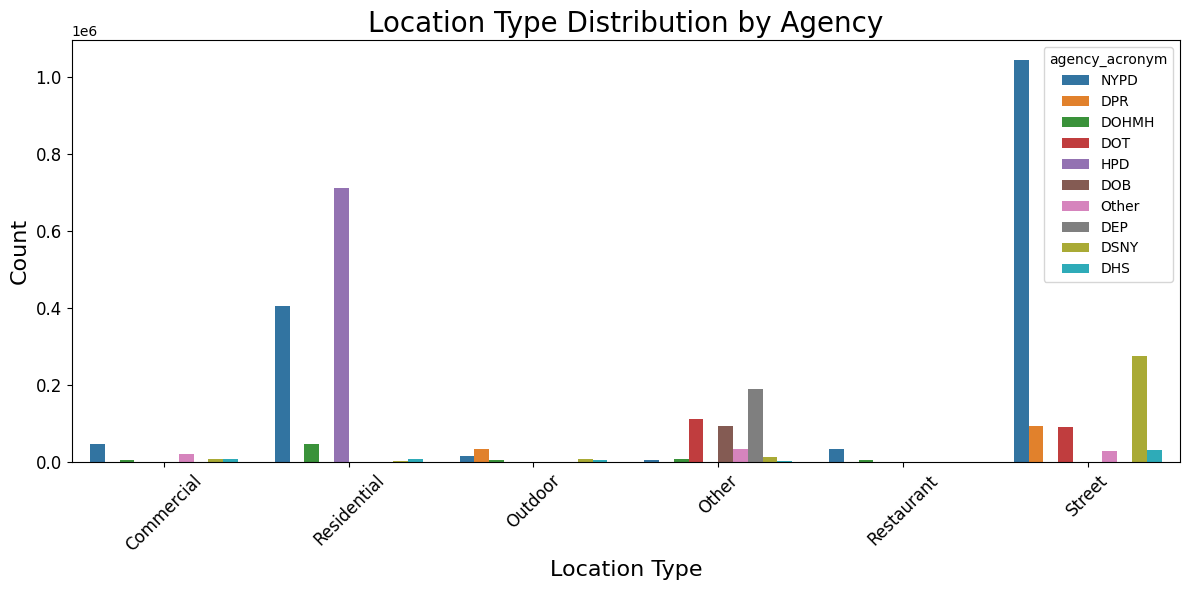

Figure saved as visualizations/location_type_by_agency.png with 300 DPI.


In [51]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'location_type', hue = 'agency_acronym', ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Location Type Distribution by Agency', 'Location Type', 'Count')

# Rotate x-ticks for better readability
plt.xticks(rotation = 45)

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/location_type_by_agency.png')

Viewing the Borough distribution by Agency reveals that most complaints in each Borough go to the NYPD. This should be obvious from the earlier Complaints by Agency chart, but this also reveals that certain Boroughs tend towards very different agencies to handle their complaints. The Bronx has the highest rate of complaints handled by the HPD, while Queens has almost all of its complaints handled by the NYPD.

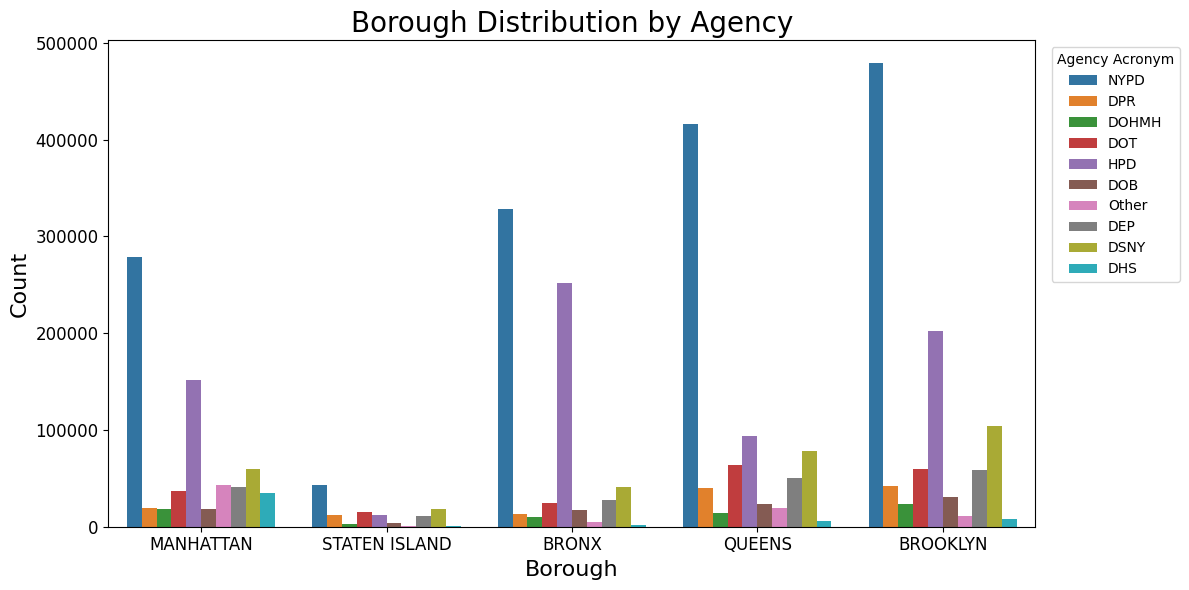

Figure saved as visualizations/borough_by_agency.png with 300 DPI.


In [52]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'borough', hue = 'agency_acronym', ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Borough Distribution by Agency', 'Borough', 'Count')

# Move legend to the right outside the plot
plt.legend(title = 'Agency Acronym', bbox_to_anchor = (1.01, 1), loc = 'upper left')

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/borough_by_agency.png')

Taking a closer look at complaint type by borough, a better picture is given. Queens has mostly Traffic complaints, followed by Noise and Building complaints, which were the top 3 categories typically handled by the NYPD. The Bronx has a much higher ratio of Building & Facility complaints which were often handled by HPD.

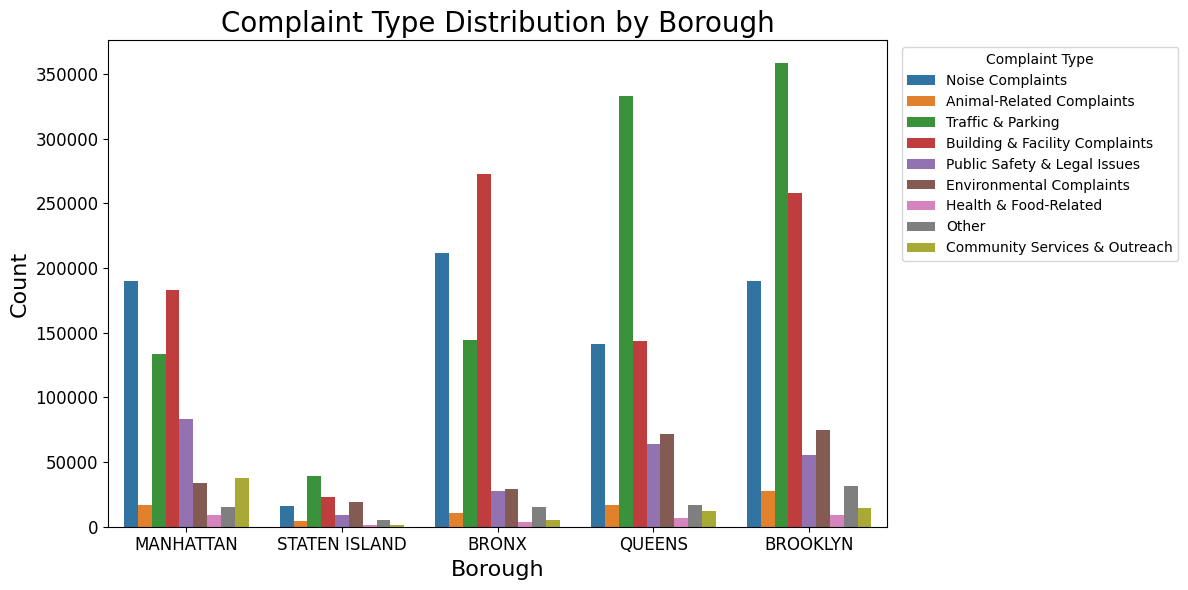

Figure saved as visualizations/complaint_type_by_borough.png with 300 DPI.


In [53]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'borough', hue = 'complaint_type', ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Complaint Type Distribution by Borough', 'Borough', 'Count')

# Move legend to the right outside the plot
plt.legend(title = 'Complaint Type', bbox_to_anchor = (1.01, 1), loc = 'upper left')

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/complaint_type_by_borough.png')

### Resolution Time and Completion Analysis

Although not useful for predicting where a complaint should be directed to, it is useful to know how long it takes to resolve complaints on average. The following plot shows that ~75% of resolved complaints are resolved in the first 24 hours, ~94% in the first month, ~98.5% in the first 3 months.

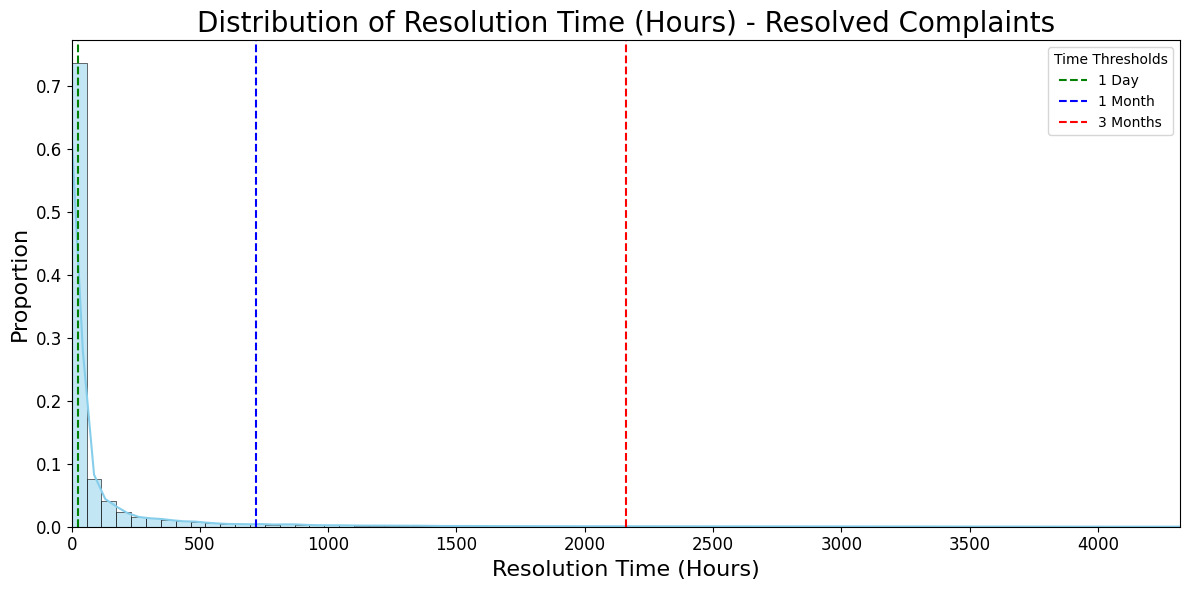

Figure saved as visualizations/resolution_time_distribution_resolved.png with 300 DPI.


In [54]:
# Filter the dataframe to only include resolved complaints
resolved_df = df[df['resolved'] == True]

# Define the thresholds in hours
one_day = 24  # 1 day in hours
one_month = 30 * 24  # 1 month in hours (approx. 30 days)
three_months = 3 * 30 * 24  # 3 months in hours (approx. 90 days)
six_months = 6 * 30 * 24  # 3 months in hours (approx. 90 days)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(resolved_df['resolution_time_hours'], bins = 150, kde = True,
             stat = 'probability', color = 'skyblue', ax = ax)

# Add dotted lines for 1 day, 1 month, and 3 months
ax.axvline(x = one_day, color = 'green', linestyle = '--', label = '1 Day')
ax.axvline(x = one_month, color = 'blue', linestyle = '--', label = '1 Month')
ax.axvline(x = three_months, color = 'red', linestyle = '--', label = '3 Months')

# Set x-axis limit to 6 months (approx. 180 days)
ax.set_xlim(0, six_months)

# Format plot
format_axis(ax, 'Distribution of Resolution Time (Hours) - Resolved Complaints',
            'Resolution Time (Hours)', 'Proportion')

# Add legend
plt.legend(title = "Time Thresholds")

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/resolution_time_distribution_resolved.png')

Grouping by agency, we see that the NYPD usually resolves complaints very quickly (< 1 day), while agencies like the DPR (Department of Parks and Recreation) and DOB (Department of Buildings) take significantly longer to resolve complaints.

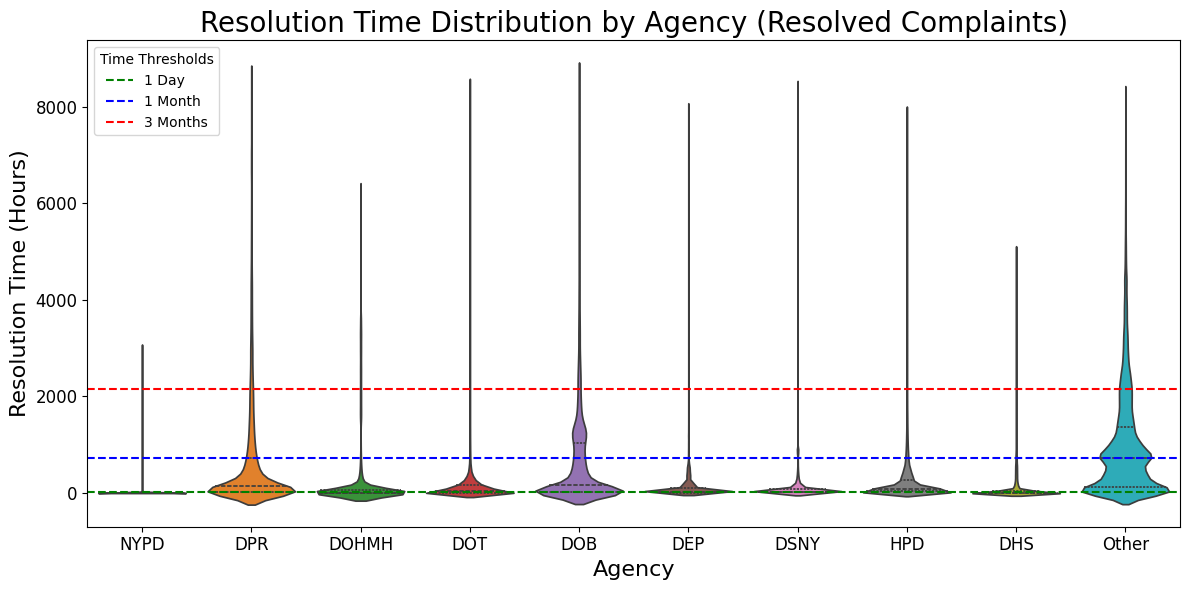

Figure saved as visualizations/resolution_time_by_agency_resolved.png with 300 DPI.


In [55]:
# Create the plot using the filtered dataframe (resolved_df)
fig, ax = plt.subplots(figsize = (12, 6))
sns.violinplot(data = resolved_df, x = 'agency_acronym', y = 'resolution_time_hours', hue = 'agency_acronym',
               inner = 'quartile', density_norm = 'width', ax = ax, palette = 'tab10')

# Add dotted lines for 1 day, 1 month, and 3 months
ax.axhline(y = one_day, color = 'green', linestyle = '--', label = '1 Day')
ax.axhline(y = one_month, color = 'blue', linestyle = '--', label = '1 Month')
ax.axhline(y = three_months, color = 'red', linestyle = '--', label = '3 Months')

# Format plot
format_axis(ax, 'Resolution Time Distribution by Agency (Resolved Complaints)', 'Agency', 'Resolution Time (Hours)')

# Add legend
plt.legend(title = "Time Thresholds", loc = "upper left")

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/resolution_time_by_agency_resolved.png')

The resolution rate per agency helps to determine how effective each agency is at resolving complaints. Most of the agencies have resolution ratios in the 94-100% range within 1 year (the span of the slice of data used), but the DHS (Department of Homeless Services) and DPR have much lower resolution rates.

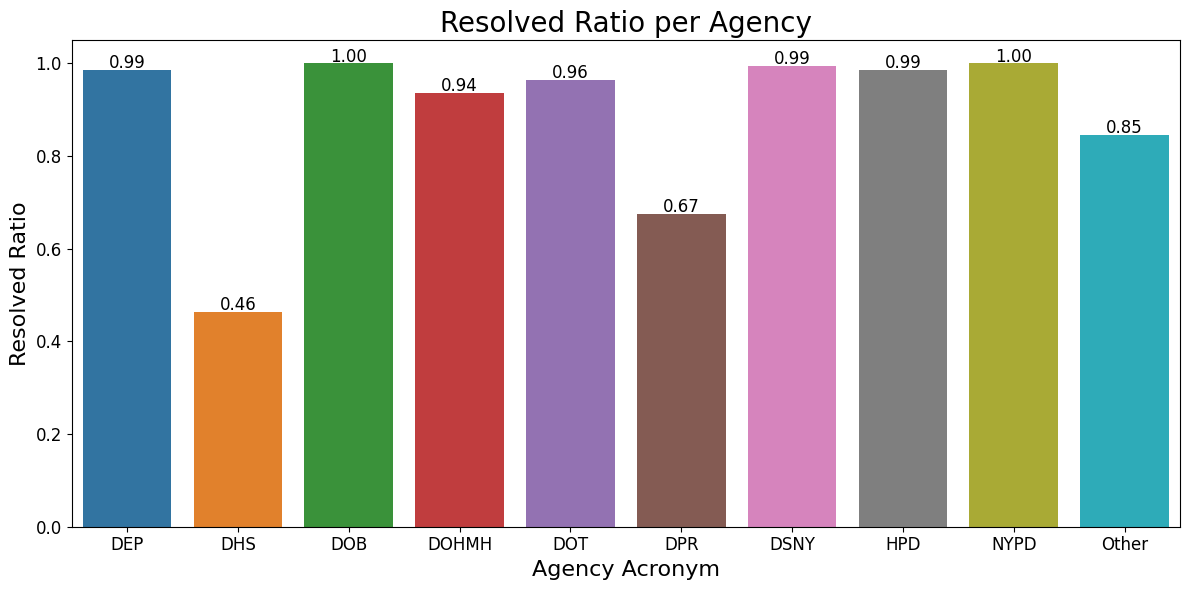

Figure saved as visualizations/resolved_ratio_by_agency.png with 300 DPI.


In [56]:
# Calculate resolved ratio per agency
resolved_ratio = df.groupby('agency_acronym')['resolved'].mean().reset_index()

# Plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(data = resolved_ratio, x = 'agency_acronym', y = 'resolved', ax = ax,
            hue = 'agency_acronym', palette = 'tab10')

# Add annotations
add_bar_labels(ax)

# Format plot
format_axis(ax, 'Resolved Ratio per Agency', 'Agency Acronym', 'Resolved Ratio')
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/resolved_ratio_by_agency.png')

### Temporal Patterns

The next step is to see if there are any temporal patterns to the complaints. The raw number of complaints is highest in the afternoon (12:00pm to 5:59pm) and lowest during the night (12:00am to 5:59 am), which is to be expected as there is more activity during the middle of the day compared to the night. The number of complaints during daytime hours are all close.

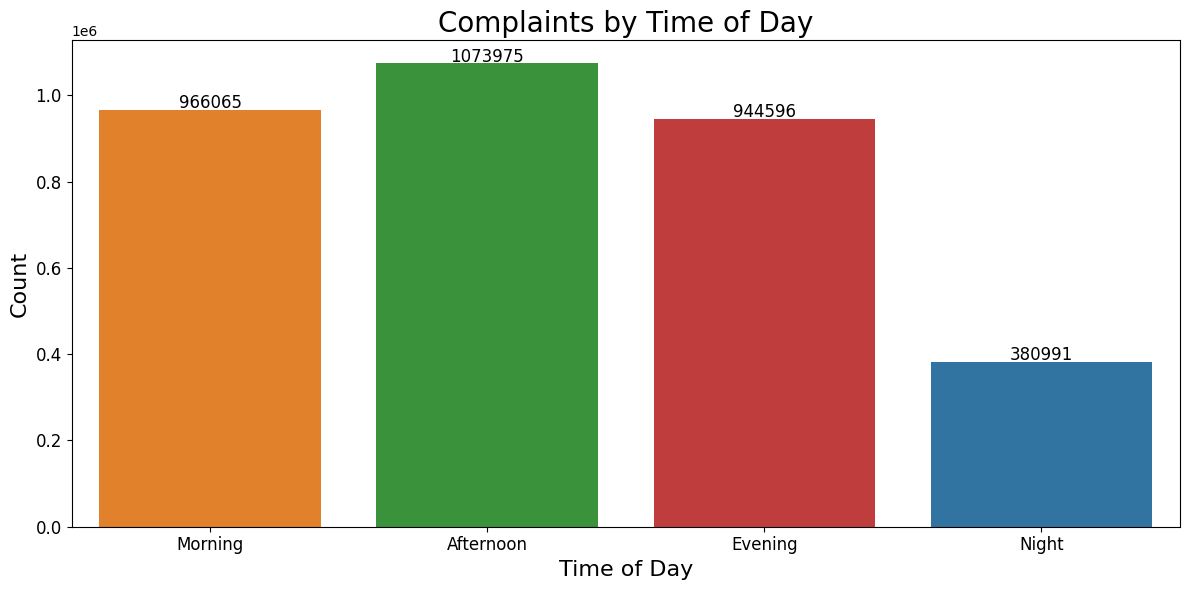

Figure saved as visualizations/complaints_by_time_of_day.png with 300 DPI.


In [57]:
# Define time of day order
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']

# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'time_of_day', hue = 'time_of_day', order = time_order, palette = 'tab10', ax = ax)

# Format and annotate
format_axis(ax, 'Complaints by Time of Day', 'Time of Day', 'Count')
add_bar_labels(ax, fmt = "{:.0f}")
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/complaints_by_time_of_day.png')

As expected, most of the agencies operate during the daylight hours, with only the NYPD having any significant presence during the nighttime hours.

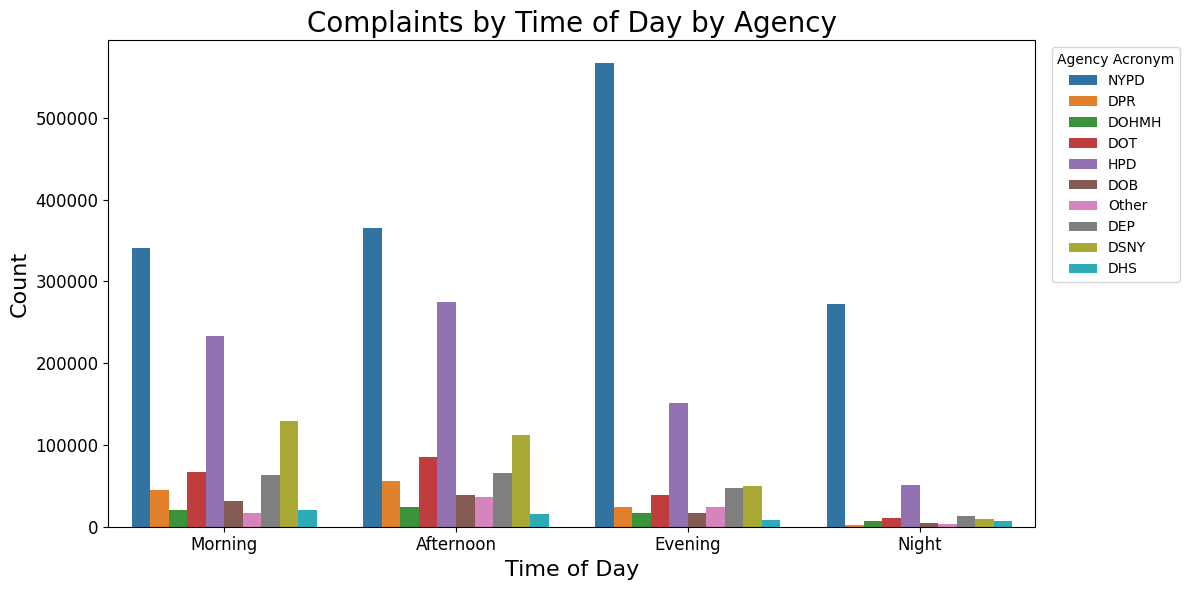

Figure saved as visualizations/complaints_by_time_of_day_by_agency.png with 300 DPI.


In [58]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'time_of_day', hue = 'agency_acronym', order = time_order, ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Complaints by Time of Day by Agency', 'Time of Day', 'Count')

# Move legend to the right
plt.legend(title = 'Agency Acronym', bbox_to_anchor = (1.01, 1), loc = 'upper left')

# Adjust x-ticks and layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/complaints_by_time_of_day_by_agency.png')

Checking the number of complaints across the course of the week shows an interesting trend. Complaints are more likely to occur earlier in the week, trending downwards until the weekend. This seems to indicate that people are less likely to call 311 later on in the week, instead deferring any non-urgent complaints until the start of the work-week.

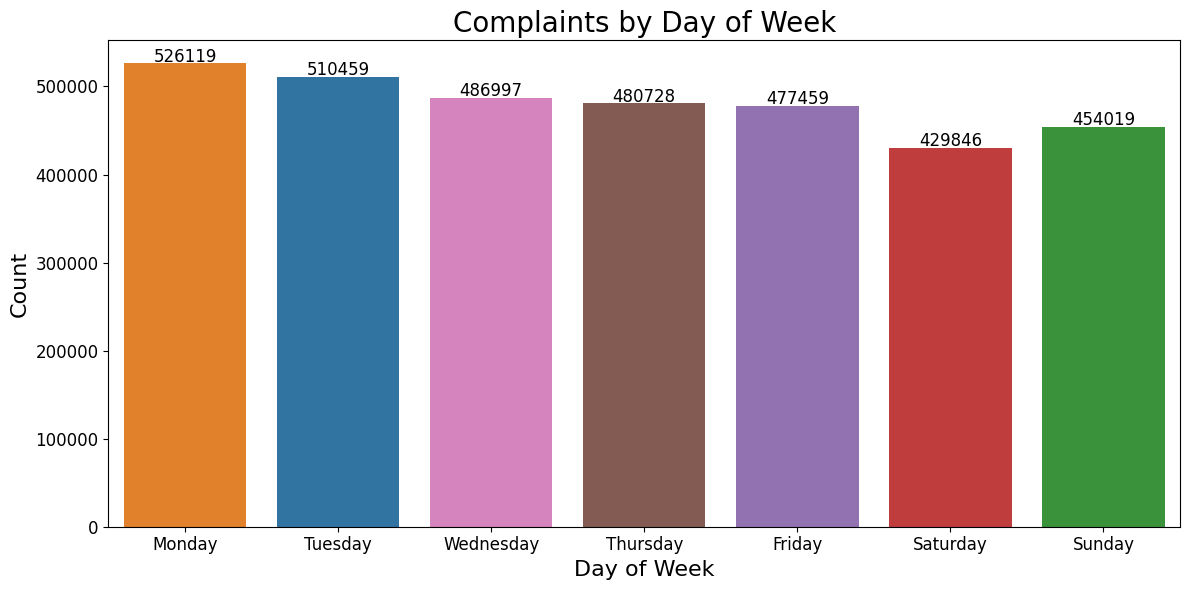

Figure saved as visualizations/complaints_by_day_of_week.png with 300 DPI.


In [59]:
# Ensure correct day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'day_of_week', hue = 'day_of_week', order = day_order, palette = 'tab10', ax = ax)

# Add annotations
add_bar_labels(ax, fmt = "{:.0f}")

# Format plot
format_axis(ax, 'Complaints by Day of Week', 'Day of Week', 'Count')
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/complaints_by_day_of_week.png')

Viewing the complaints by day of week broken down by agency reveals that the NYPD is the main agency handling complaints over the weekend. This makes sense, as most of the other agencies operate under normal business hours.

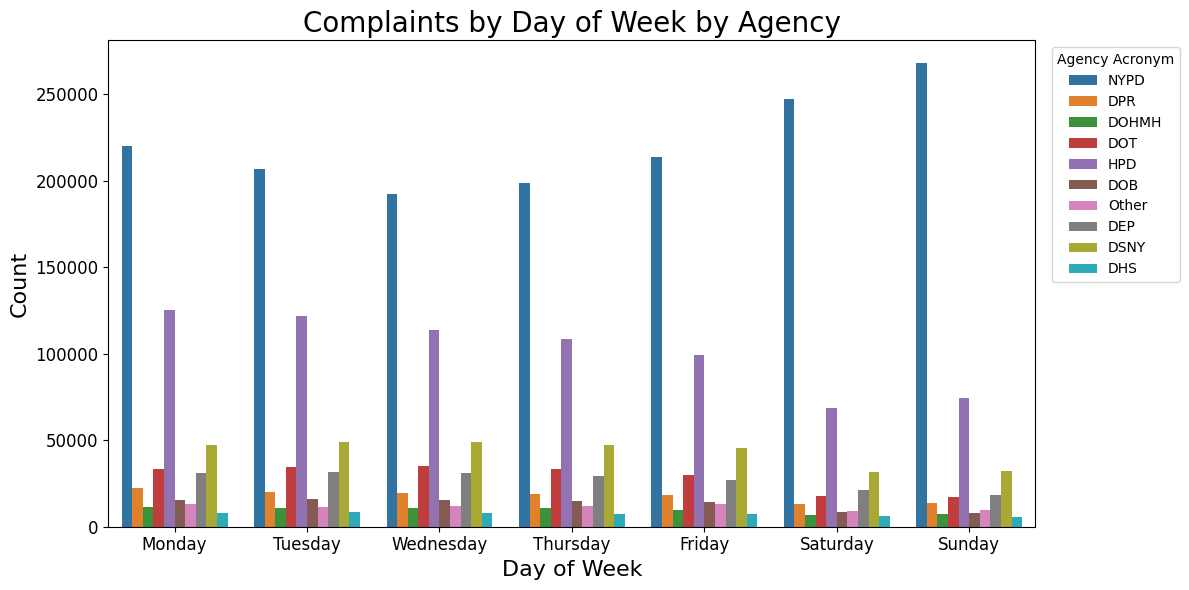

Figure saved as visualizations/complaints_by_day_of_week_by_agency.png with 300 DPI.


In [60]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'day_of_week', hue = 'agency_acronym', order = day_order, ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Complaints by Day of Week by Agency', 'Day of Week', 'Count')

# Move legend to the right
plt.legend(title = 'Agency Acronym', bbox_to_anchor = (1.01, 1), loc = 'upper left')

# Adjust x-ticks and layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/complaints_by_day_of_week_by_agency.png')

The majority of complaints over the weekend are noise complaints, which makes sense as these are the days of the week when events such as parties, etc. are held and most people are at home. Noise complaints are handled almost exclusively by the NYPD, which explains why the NYPD is the most prevalent agency answering 311 calls over the weekend.

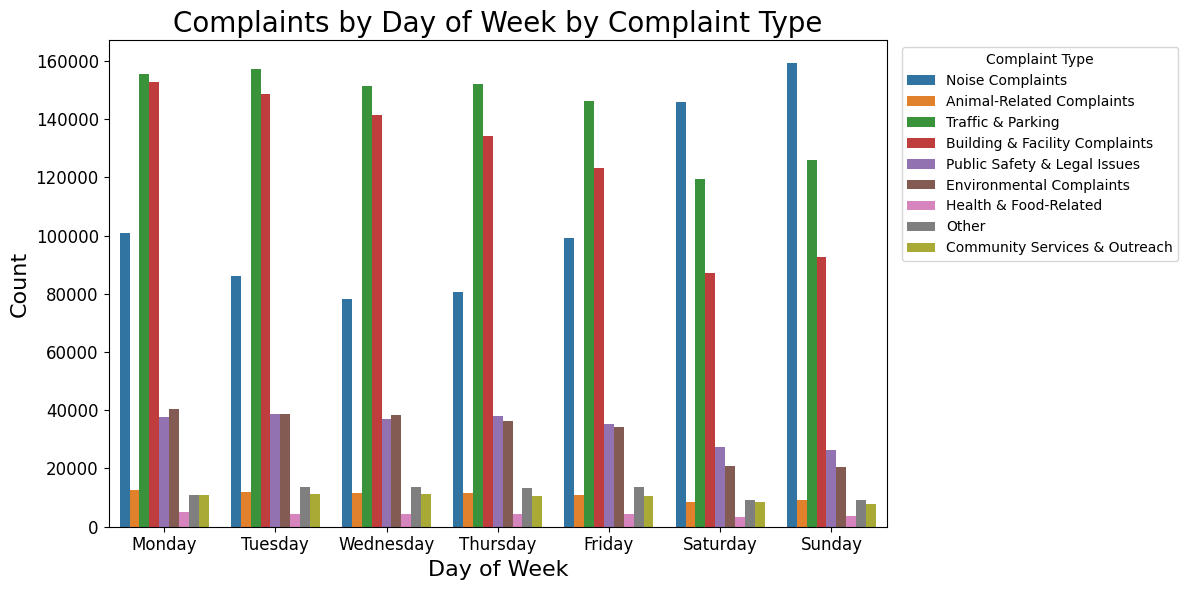

Figure saved as visualizations/complaints_by_day_of_week_by_complaint_type.png with 300 DPI.


In [61]:
# Ensure correct day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'day_of_week', hue = 'complaint_type',
              order = day_order, palette = 'tab10', ax = ax)

# Format plot
format_axis(ax, 'Complaints by Day of Week by Complaint Type', 'Day of Week', 'Count')

# Move legend to the right
plt.legend(title = 'Complaint Type', bbox_to_anchor = (1.01, 1), loc = 'upper left')

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/complaints_by_day_of_week_by_complaint_type.png')

Viewing the number of complaints by month shows that there appear to be generally more complaints during the summer and fall months, with comparatively few in spring. February is an outlier, as expected since it is shorter, but otherwise, the level of complaints stays roughly the same throughout the year.

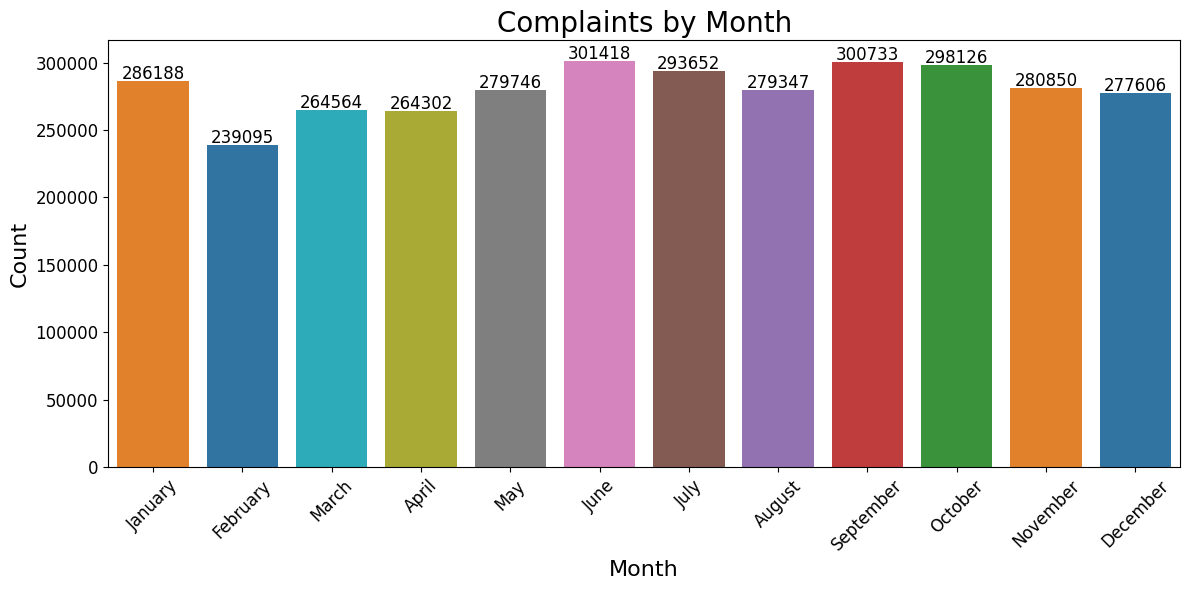

Figure saved as visualizations/complaints_by_month.png with 300 DPI.


In [62]:
# Month names order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'month', order = month_order, ax = ax, hue = 'month', palette = 'tab10')
format_axis(ax, 'Complaints by Month', 'Month', 'Count')
add_bar_labels(ax, fmt = '{:.0f}')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/complaints_by_month.png')

Looking at the distribution of complaints by month, it becomes clear that there are many more housing complaints handled by the HPD during the winter months (January and December) and more sanitation or enivornmental complaints handled by the DSNY (Department of Sanitation) and the DEP (Department of Environmental Protection) during the summer. Complaints handled by the NYPD seem to also increase during the Summer and Fall months.

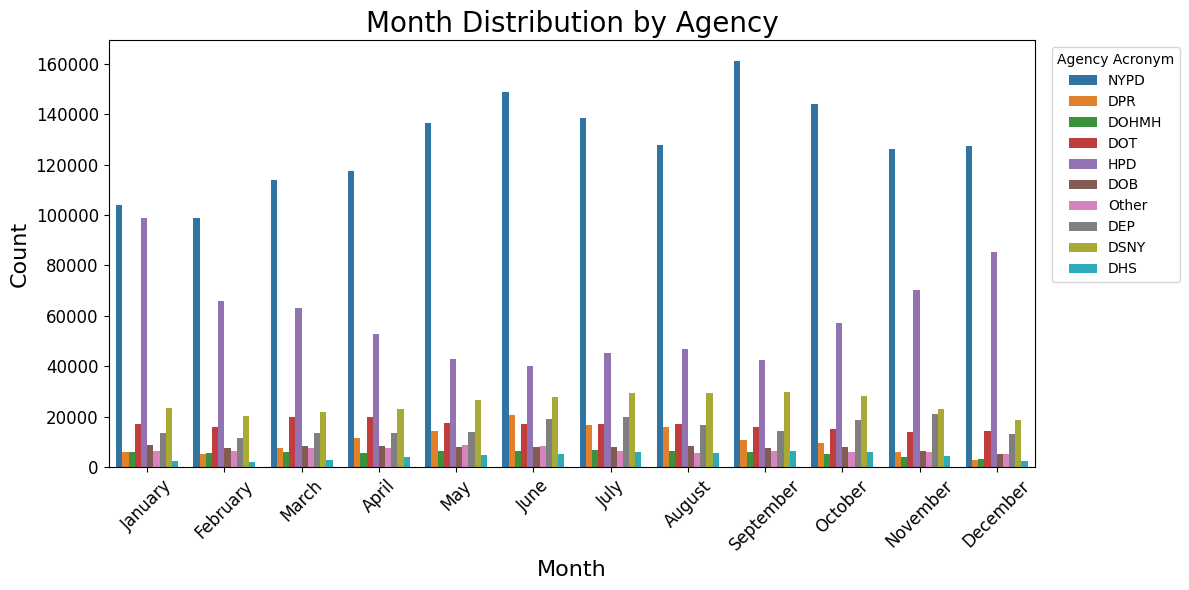

Figure saved as visualizations/complaints_by_month_by_agency.png with 300 DPI.


In [63]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'month', hue = 'agency_acronym', order = month_order, ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Month Distribution by Agency', 'Month', 'Count')

# Move legend to the right
plt.legend(title = 'Agency Acronym', bbox_to_anchor = (1.01, 1), loc = 'upper left')

# Adjust x-ticks and layout
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/complaints_by_month_by_agency.png')

### Correlation and Feature Analysis

Most of the relevant features for modeling in the data are categorical. As such, correlation heatmaps are not useful, so we perform a pair-wise Chi-squared test for independence on each categorical feature to see if the features are independent. High Chi-square values / low p-values indicate that the variables are not independent and have a relationship between them.

In [64]:
# Select only categorical columns
categorical_cols = ['complaint_type', 'location_type', 'borough', 'incident_zip',
                    'time_of_day', 'day_of_week', 'month', 'agency_acronym', ]

# Store results
chi2_results = []

# Loop over all combinations of categorical columns
for col1, col2 in combinations(categorical_cols, 2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    
    if contingency_table.size > 1:  # skip if degenerate
        chi2, p, dof, expected = chi2_contingency(contingency_table, correction = False)
        chi2_results.append({
            'Feature 1': col1,
            'Feature 2': col2,
            'Chi2': chi2,
            'p-value': p,
            'Degrees of Freedom': dof
        })

# Convert results to a DataFrame and sort by p-value
chi2_df = pd.DataFrame(chi2_results).sort_values(by = 'p-value')

# Display results
print(chi2_df)

         Feature 1       Feature 2          Chi2  p-value  Degrees of Freedom
0   complaint_type   location_type  2.674492e+06      0.0                  40
1   complaint_type         borough  3.263001e+05      0.0                  32
2   complaint_type    incident_zip  1.102338e+06      0.0                1944
3   complaint_type     time_of_day  4.493024e+05      0.0                  24
4   complaint_type     day_of_week  1.166330e+05      0.0                  48
5   complaint_type           month  1.198469e+05      0.0                  88
6   complaint_type  agency_acronym  8.828911e+06      0.0                  72
7    location_type         borough  2.488170e+05      0.0                  20
8    location_type    incident_zip  7.365833e+05      0.0                1215
9    location_type     time_of_day  8.560351e+04      0.0                  15
10   location_type     day_of_week  2.483991e+04      0.0                  30
11   location_type           month  8.475542e+04      0.0       

All of the chi-squared p-values are below 0.05, indicating significant relations between variables. However, by looking at the normalized chi-squared value (chi-squared / degrees of freedom), it becomes clear that the most relevant values to the target variable agency_acronym are complaint type, location type, time of day, and borough. Location type and complaint type do appear to be highly related as well.

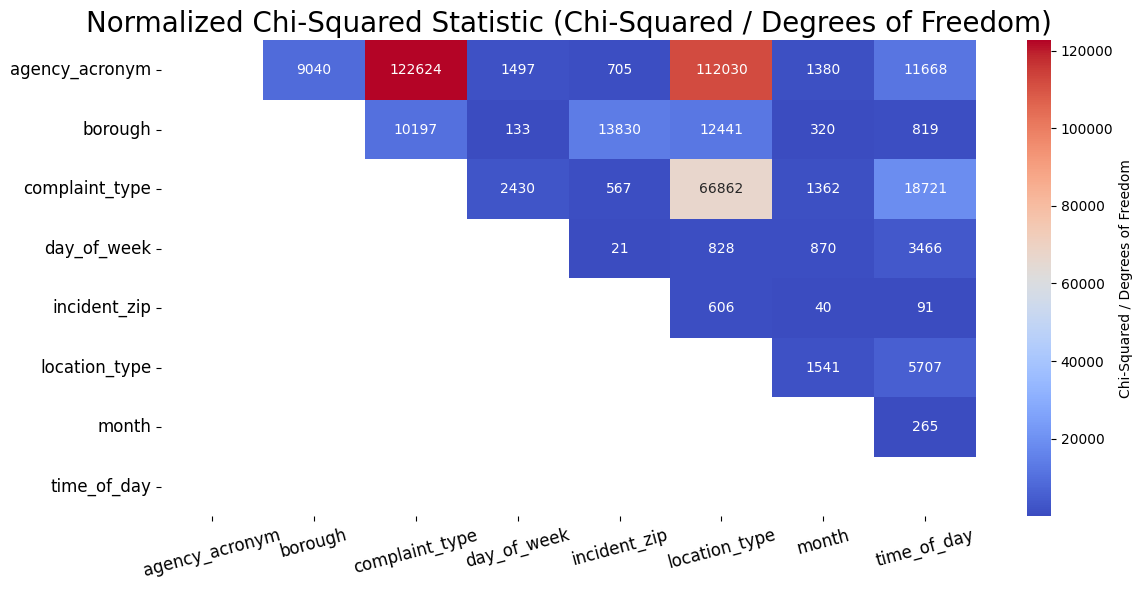

Figure saved as visualizations/chi_squared_correlations.png with 300 DPI.


In [65]:
# Create a matrix for normalized Chi-squared (Chi-squared / degrees of freedom)
chi2_df['Chi2_norm'] = chi2_df['Chi2'] / chi2_df['Degrees of Freedom']

features = sorted(set(chi2_df['Feature 1']).union(chi2_df['Feature 2']))
norm_matrix = pd.DataFrame(np.nan, index=features, columns=features)

# Fill matrix with normalized Chi-squared statistic
for _, row in chi2_df.iterrows():
    f1, f2, chi2_norm = row['Feature 1'], row['Feature 2'], row['Chi2_norm']
    norm_matrix.loc[f1, f2] = chi2_norm
    norm_matrix.loc[f2, f1] = chi2_norm

# Create the mask for the lower triangle
mask = np.tril(np.ones_like(norm_matrix, dtype = bool))

# Plot heatmap
fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(norm_matrix, annot = True, fmt = ".0f", cmap = "coolwarm",
            mask = mask, cbar_kws = {'label': 'Chi-Squared / Degrees of Freedom'})
format_axis(ax, 'Normalized Chi-Squared Statistic (Chi-Squared / Degrees of Freedom)', '', '')
plt.xticks(rotation = 15)
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = 'visualizations/chi_squared_correlations.png')

### Spatial Analysis (GeoPandas map using Folium)

Some testing with GeoPandas to see how the complaints are distributed graphically on a map. Not much to be gained from this visual other than to be able to explore how the complaints appear spatially in a visual sense.

In [24]:
# Regenerate the geometry column for spatial plotting (this takes a long time to run)
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis = 1)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry = 'geometry', crs = 'EPSG:4326')

In [25]:
# Note: This may take a long time to run!
# Create a folium map centered around the average location of all boroughs
center_lat, center_lon = df['geometry'].apply(lambda x: x.y if isinstance(x, Point) else None).mean(), \
                        df['geometry'].apply(lambda x: x.x if isinstance(x, Point) else None).mean()

m = folium.Map(location = [center_lat, center_lon], zoom_start = 11, tiles = 'cartodbpositron')

# Create a MarkerCluster to group markers
marker_cluster = MarkerCluster().add_to(m)

# Group by borough and sample 0.1% of the data for each borough
sampled_df = df.groupby('borough').apply(
    lambda x: x.sample(frac = 0.001)
).reset_index(drop = True)

# Generate a color palette for each borough
boroughs = sampled_df['borough'].unique()
color_palette = sns.color_palette("tab10", n_colors = len(boroughs))
borough_color_map = {borough: color_palette[i] for i, borough in enumerate(boroughs)}

# Add CircleMarkers for each sampled point, color-coded by borough
for _, row in sampled_df.iterrows():
    color = borough_color_map[row['borough']]
    
    folium.CircleMarker(
        location = [row['latitude'], row['longitude']],
        radius = 4,
        color = f'rgba({int(color[0] * 255)}, {int(color[1] * 255)}, {int(color[2] * 255)}, 1)', # RGB color
        fill = True,
        fill_opacity = 0.4,
        popup = f"Complaint ID: {row.name}<br>Borough: {row['borough']}",
    ).add_to(marker_cluster)

# Display the map
m

/tmp/ipykernel_75230/234327185.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('borough').apply(


### Remove Extra Columns in Preparation for Modeling

In [66]:
# Inspect columns to see which need to be removed
df.columns

Index(['agency_name', 'complaint_type', 'location_type', 'incident_zip',
       'borough', 'latitude', 'longitude', 'time_of_day', 'day_of_week',
       'month', 'resolution_time_hours', 'resolved', 'agency_acronym'],
      dtype='object')

We don't need agency name anymore, as it is equivalent to agency acronym but longer. We don't need the Latitude and Longitude spatial data for modeling, nor do we need the time to resolution or resolution status to predict which agency the 311 call should be directed towards, as these features are calculated after the fact. Day of Week and Month show some interesting patterns, but the most useful categorical features appear to be Borough, Complaint Type, Location Type, and Time of Day. We will also keep the Incident Zip for modeling to preserve some amount of location data that is more granular than Borough, even though the Incident Zip does not have as strong of a relation from the Chi-Squared tests.

In [67]:
# Subset on columns for modeling
df = df[['agency_acronym', 'borough', 'complaint_type', 'location_type', 'time_of_day', 'incident_zip']]

# Step 3: Modeling

### Preprocess Data

The first step is to split the data into X and y features and then to perform a train-test split. Although it should not matter for our dataset, generally it is best to perform a train-test split before doing encoding and scaling so that there is no data leakage. For example, if using StandardScaler on the full dataset, the StandardScaler will learn mean and standard deviation from testing data which is poor practice.

In [68]:
# Define features and target
X = df.drop('agency_acronym', axis = 1)
y = df['agency_acronym']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

We need to convert all of the columns in X into one-hot encoded columns using OneHotEncoder, as they are all categorical. If there were any numerical columns, it would be best to scale them as well using StandardScaler, but that is not necessary in this case. We do not drop any of the columns when one-hot-encoding, because even though this introduces multicollinearity, we will handle this multicollinearity via regularization.

In [69]:
# Because all of the columns in X are categorical, we use all of the columns for OneHotEncoding
categorical_columns = X.columns.tolist()

# Create the ColumnTransformer with OneHotEncoder
# Not dropping first as multicollinearity will be handled by regularization
ohe = ColumnTransformer(
    transformers = [
        ('onehot', OneHotEncoder(), categorical_columns)
    ],
    remainder = 'drop'
)

# Fit the preprocessor to the training data and transform the training and testing data
# Sparse matrices to speed up calculations and save memory
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

Next, we need to convert the target variable into numerical outputs using LabelEncoder so that the values are from 0 to n_classes - 1 rather than as strings.

In [70]:
# Instantiate encoder
label_encoder = LabelEncoder()

# Fit and transform y series
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### Training

#### Helper Functions

Before training, it is important to consider what an appropriate scoring metric is for using the GridSearch scoring.

In the context of this project's task, Precision measures the ability of the model to correctly direct the caller to the correct agency. A low Precision means that callers are often erroneously directed to that agency. While it is possible that the caller could be redirected to the appropriate agency afterwards, that scenario involves wasted time and manpower spent redirecting the call which is not ideal when dealing with agencies such as the NYPD. Thus, Precision is a valuable metric.

Recall measures the ability of the model to correctly capture all of the callers that should be directed to the correct agency. A low Recall means that the callers that should be directed to a given agency are not being directed there. This leads to lower resolution rates, longer times to resolve problems, and a general lack of effectiveness in the 311 system. Therefore, Recall is a valuable metric.

Since both Precision and Recall are important, the score we will maximize is the Macro F1-Score. Macro F1-Score is used over Weighted because it treats each class as equally important, which is necessary because there are large class imbalances and it would not be helpful for the more prevalent classes to dominate the less prevalent ones. Because there are class imbalances, Accuracy is not the most reliable metric and will not be used as the primary scorer.

We will use 3-fold cross-validation in the GridSearchCV to perform hyperparameter tuning. The number of folds needs to be low because the size of the data is large enough that training takes a long time. The entire training process will be timed to get a sense of computational complexity and along with the fit time for the best found model for each grid search they will be put into a dictionary. The best model will also be captured and added to the dictionary before finally being pickled to allow for loading at a later time.

In [71]:
# Helper function to train models
def run_gridsearch_and_save(classifier, param_grid, X_train, y_train, pickle_filename):
    # Record start time for the overall fitting process
    start_time = time.time()

    # Setup GridSearchCV with f1_macro as the scoring metric
    grid_search = GridSearchCV(
        estimator = classifier,
        param_grid = param_grid,
        cv = 3, # Reduced number of cross-validation folds to save time due to dataset size
        scoring = 'f1_macro',
        n_jobs = -1,
        verbose = 1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)

    # Record total fit time
    total_fit_time = time.time() - start_time

    # Extract relevant information
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_model_fit_time = grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]
    num_models_tested = len(grid_search.cv_results_['params'])

    # Create a dictionary to store the results
    result_dict = {
        'model_name': classifier.__class__.__name__,
        'best_model': best_model,
        'total_fit_time': total_fit_time,
        'num_models_tested': num_models_tested,
        'best_model_fit_time': best_model_fit_time
    }

    # Save the result dictionary to a pickle file
    with open(pickle_filename, 'wb') as f:
        pickle.dump(result_dict, f)

    print(f"Grid search completed. Results saved to {pickle_filename}")

    return

In [72]:
# Helper function to load pickled models
def load_pickle(path):
    with open(path, 'rb') as f:
        model = pickle.load(f)

    return model

#### Model Fitting / Loading

The four model types tested are Logistic Regression via the SGDClassifier (in order to implement Stochastic Gradient Descent), a DecisionTreeClassifier and RandomForestClassifier (non-parametric models that cannot use Gradient Descent), and finally an XGBClassifier to test a boosted model that has its own learning rate. The parameter grids are deliberately small to cut down on training time. It is not ideal, but the size of the data and power of the machines available to us restricts our ability to do a more exhaustive grid search. Details of the parameters searched are noted in each cell. Each of the models were trained in Google Colab using a high memory instance (hence no print statements in this notebook).

Logistic regression is tested with various levels of regularization strength and testing different balances of L1 (Lasso) vs. L2 (Ridge) regularization using ElasticNet. To take advantage of the SGDClassifier, different learning rates are testing using the adaptive strategy which keeps the learning rate the same until no changes happen then divides the learning rate by 5 and continues.

The best model used a starting learning rate of 0.1, an L1 ratio of 0.85 and the default regularization strength of 0.0001. This parameter grid fit 27 different models using 3-fold validation for a total of 81 models and had the second worst model fit time of \~387 seconds (\~6.5 minutes).

In [73]:
# LogisticRegression via SGDClassifier
param_grid = {
    'loss': ['log_loss'],               # Log loss makes SGDClassifier equivalent to LogisticRegression
    'penalty': ['elasticnet'],          # Use the ElasticNet regularization penalty
    'alpha': [1e-4, 1e-3, 1e-2],        # Regularization strength
    'l1_ratio': [0.15, 0.5, 0.85],      # Percentage of the regularization weighted towards L1 vs. L2
    'learning_rate': ['adaptive'],      # Setting the learning rate to adaptive to adjust learning rate
    'eta0': [0.001, 0.01, 0.1],         # Initial learning rate
    'max_iter': [1000],                 # Maximum iterations for each model
    'tol': [1e-3],                      # Stopping criterion
}

# run_gridsearch_and_save(SGDClassifier(), param_grid, X_train, y_train, '../models/logistic_regression.pkl')

logistic_regression = load_pickle('models/logistic_regression.pkl')
logistic_regression

{'model_name': 'SGDClassifier',
 'best_model': SGDClassifier(eta0=0.1, l1_ratio=0.85, learning_rate='adaptive',
               loss='log_loss', penalty='elasticnet'),
 'total_fit_time': 3945.7306056022644,
 'num_models_tested': 27,
 'best_model_fit_time': np.float64(387.56030400594074)}

The Decision Tree is tested with a few different options for maximum depth and minimum samples split. Decision Trees are prone to overfitting so it is often helpful to reduce the maximum depth or increase the minimum samples required to create splits. Increasing the minimum samples per leaf helps prevent the tree from making sparse branches that separate very small amounts of data. Weighting based on class balances was tested to see if it was helpful due to class imbalances.

The best model had the default values for max depth (None) and minimum samples split (2), likely due to the extensive preprocessing done on the data which helped to prevent extreme overfitting. The minimum samples leaf being slightly increased to 4 (from the default of 1) was beneficial. Weighting for class balances was not beneficial. 24 different models were fit using 3-fold validation for a total of 72 models. The parameter grid could possibly have been made larger, but it was kept fairly small for time constraints. The decision tree had the second fastest fit time of 195 seconds (3.25 minutes).

In [74]:
# DecisionTreeClassifier
param_grid = {
    'max_depth': [10, 20, None],        # Maximum depth of tree to reduce complexity and avoid overfitting
    'min_samples_split': [2, 10],       # Minimum samples to split to reduce complexity and avoid overfitting
    'min_samples_leaf': [1, 4],         # Minimum samples per leaf to reduce complexity
    'class_weight': [None, 'balanced']  # Weights for each class to address class imbalances
}
# run_gridsearch_and_save(DecisionTreeClassifier(random_state = 42), param_grid,
                        # X_train, y_train, '../models/decision_tree.pkl')

decision_tree = load_pickle('models/decision_tree.pkl')
decision_tree

{'model_name': 'DecisionTreeClassifier',
 'best_model': DecisionTreeClassifier(min_samples_leaf=4, random_state=42),
 'total_fit_time': 1043.8672311306,
 'num_models_tested': 24,
 'best_model_fit_time': np.float64(195.22301697731018)}

The Random Forest was tested with similar parameters to the Decision Tree. The max depth for each tree does not need to be the as large as the Decision Trees, as the Random Forest is meant to use an ensemble of weaker learners. Random Forest is notably much slower to train, so the parameter grid is deliberately very small to help reduce training time. Random Forests tend to perform well without significant hyperparameter tuning.

The best model used a max depth of 10 with 200 estimators and the default minimum samples split of 2 (identical to the performance of the Decision Tree). The model likely could have benefitted from a larger number of estimators due to the sheer size of the dataset but training times made that impractical. 8 models were fit using 3-fold cross validation for a total of 24 models. The Random Forest had the worst computational complexity performance with a fit time of 673 seconds (~11 minutes).

In [75]:
# RandomForest Classifier
param_grid = {
    'n_estimators': [100, 200],          # Number of trees to use for boosting
    'max_depth': [5, 10],                # Maximum depth of each tree to reduce complexity and avoid overfitting
    'min_samples_split': [2, 10],        # Minimum samples to split to reduce complexity and avoid overfitting
}
# run_gridsearch_and_save(RandomForestClassifier(random_state = 42), param_grid,
#                         X_train, y_train, '../models/random_forest.pkl')

random_forest = load_pickle('models/random_forest.pkl')
random_forest

{'model_name': 'RandomForestClassifier',
 'best_model': RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42),
 'total_fit_time': 1856.613802909851,
 'num_models_tested': 8,
 'best_model_fit_time': np.float64(673.4580012162527)}

Note that XGBoost has a different setup than the typical sklearn models. The function for fitting and training the models was not customized to adjust for the XGBoost architecture, which means that the pickled models must be trained and loaded on the same version of XGBoost. The version of XGBoost used was version 2.1.4.

In [76]:
# !pip install xgboost==2.1.4

XGBoost is a boosted model, so it benefits from various learning rates and a higher number of boosting rounds. The max depth can be much lower than normal decision trees or random forest since each tree learns from the prior trees. Subsample helps to control the fraction of samples used for each tree which can help prevent overfitting by not letting each tree fit on the entire training data. XGBoost also utilizes L1 and L2 regularizations.

The best model utilized a max depth of 6 with 0.01 L1 regularization and 1 L2 regularization. This has minimal regularization, but the risk of overfitting is reduced by the low max depth and by using a subsample fraction of 0.8. The best model used the larger learning rate of 0.1. It would likely be beneficial to use more estimators to have more boosting rounds, although it is possible to have too many boosting rounds and overfit the data.

Notably, XGBoost is able to utilize GPU resources for faster training. The XGBoost model was fit on the A100 GPU on Google Colab. 64 models were fit with 3-fold cross validation for a total of 192 models. The XGBoost fit 192 models in less time than the Random Forest fit 24 models. XGBoost had the best computational performance with a fit time of only 167 seconds  (~2.75 minutes).

In [77]:
# XGBoostClassifier
param_grid = {
    'n_estimators': [100, 200],          # Number of trees to use for boosting (number of boosting rounds)
    'learning_rate': [0.05, 0.1],        # Learning rate: step size for each boosting round
    'max_depth': [3, 6],                 # Maximum depth of trees
    'subsample': [0.8, 1.0],             # Fraction of samples used for each tree
    'reg_alpha': [0.01, 0.1],            # L1 regularization term on weights
    'reg_lambda': [1, 1.5]               # L2 regularization term on weights
}
# run_gridsearch_and_save(XGBClassifier(random_state = 42), param_grid, X_train, y_train, '../models/xgboost.pkl')

xgboost = load_pickle('models/xgboost.pkl')
# The XGBoost model was trained on a GPU
# The tree method needs to be readjusted when loading on a model without GPU support
xgboost['best_model'].tree_method = 'auto'
xgboost

/home/josh/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:38:16] WARNING: /workspace/src/gbm/gbtree.cc:363: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
  warnings.warn(smsg, UserWarning)
/home/josh/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:38:16] WARNING: /workspace/src/gbm/gbtree.cc:388: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/home/josh/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:38:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/home/josh/.local/lib/python3.12/site-package

{'model_name': 'XGBClassifier',
 'best_model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, objective='multi:softprob', ...),
 'total_fit_time': 1687.4453814029694,
 'num_models_tested': 64,
 'best_model_fit_time': np.float64(167.11927111943564)}

In [78]:
models = [logistic_regression, decision_tree, random_forest, xgboost]

# Step 4: Evaluation and Model Selection

#### Helper Functions

In [79]:
# Helper function to plot learning curves
def plot_learning_curves(models, X, y, cv = 3,
                         train_sizes = [0.1, 0.3, 0.5, 0.8, 1],
                         random_state = 42, save_path = None):
    
    n_models = len(models)
    
    # Create subplots: one column per model
    fig, axes = plt.subplots(1, n_models, figsize = (6 * n_models, 5), sharey = True)
    
    # If only one model, make axes a list
    if n_models == 1:
        axes = [axes]
    
    # Define a color palette
    colors = plt.cm.tab10.colors  # 10 distinct colors
    
    # Define the macro F1 scorer
    scorer = make_scorer(f1_score, average = 'macro')
    
    for idx, (model_info, ax) in enumerate(zip(models, axes)):
        
        # Calculate learning curves
        train_sizes_abs, train_scores, val_scores = learning_curve(
            model_info["best_model"], X, y,
            cv = cv,
            train_sizes = train_sizes,
            scoring = scorer,
            random_state = random_state,
            n_jobs = -1
        )
        
        # Compute mean scores across folds
        train_scores_mean = np.mean(train_scores, axis = 1)
        val_scores_mean = np.mean(val_scores, axis = 1)
        
        # Convert training sizes to percentages
        train_sizes_pct = 100 * train_sizes_abs / X.shape[0]
        
        # Plot validation and training scores
        color = colors[idx % len(colors)]
        ax.plot(train_sizes_pct, val_scores_mean, label = "Validation", color = color, linestyle = '-')
        ax.plot(train_sizes_pct, train_scores_mean, label = "Training", color = color, linestyle = '--')
        
        # Format the axis using the helper
        ylabel = "Macro F1-score" if idx == 0 else ""  # Only first plot shows y-label
        format_axis(ax, model_info['model_name'], "Training Set Size (%)", ylabel)
        
        ax.grid(True)
        ax.legend()
    
    # Set a main title
    fig.suptitle("Learning Curves (Macro F1-score)", fontsize = 24)
    fig.tight_layout(rect = [0, 0, 1, 0.93])
    
    # Save the figure if requested
    if save_path is not None:
        with open(save_path, 'wb') as f:
            pickle.dump(fig, f)
    
    plt.show()

In [80]:
# Helper function to generate baseline model (random guessing based on class distribution)
def generate_random_baseline(y):
    # Get class probabilities
    classes = np.unique(y)
    class_counts = np.bincount(y)
    class_probabilities = class_counts / len(y)
    
    # Generate random predictions based on class distribution
    random_predictions = np.random.choice(classes, size = len(y), p = class_probabilities)

    # Calculate metrics for the random baseline
    accuracy = accuracy_score(y, random_predictions)
    macro_precision = precision_score(y, random_predictions, average = 'macro', zero_division = 0)
    macro_recall = recall_score(y, random_predictions, average = 'macro', zero_division = 0)
    macro_f1 = f1_score(y, random_predictions, average = 'macro', zero_division = 0)

    return accuracy, macro_precision, macro_recall, macro_f1

In [81]:
# Helper function for generating a condensed classification report table as a Pandas Styled object
def generate_classification_report_table(models_list, X_test, y_test):
    records = []
    
    # Get metrics for baseline model (using y_test) that predicts according to class probabilities
    baseline_metrics = generate_random_baseline(y_test)
    
    # Append baseline model to records
    records.append({
        'Model Name': 'Random Baseline',
        'Accuracy': round(baseline_metrics[0], 3),
        'Macro Precision': round(baseline_metrics[1], 3),
        'Macro Recall': round(baseline_metrics[2], 3),
        'Macro F1 Score': round(baseline_metrics[3], 3),
        'Models Tested': 0,  # No models tested for baseline
        'Best Fit Time (min)': 0  # No fit time for baseline
    })

    # For the rest of the models
    for model_info in models_list:
        # Create predictions
        y_pred = model_info['best_model'].predict(X_test)

        # Calculate metrics, using macro averages and accounting for possible zero division
        accuracy = accuracy_score(y_test, y_pred)
        macro_precision = precision_score(y_test, y_pred, average = 'macro', zero_division = 0)
        macro_recall = recall_score(y_test, y_pred, average = 'macro', zero_division = 0)
        macro_f1 = f1_score(y_test, y_pred, average = 'macro', zero_division = 0)

        # Convert fit time to minutes
        best_fit_time_minutes = model_info['best_model_fit_time'] / 60
        
        # Append record, rounding all float values to 3 decimals
        records.append({
            'Model Name': model_info['model_name'],
            'Accuracy': accuracy,
            'Macro Precision': macro_precision,
            'Macro Recall': macro_recall,
            'Macro F1 Score': macro_f1,
            'Models Tested': model_info['num_models_tested'],
            'Best Fit Time (min)': best_fit_time_minutes
        })

    # Create DataFrame to hold records
    report_df = pd.DataFrame(records)

    # Style DataFrame
    styled_report = (
        report_df.style
        .set_caption(
            "<b style='font-size:16px; color:white'>Overall Classification Report</b>"
        ) # Bold larger table title
        .format(precision = 4)  # Ensure 4 decimal places
        .highlight_max(subset = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1 Score'], 
                       color = '#355C7D', axis = 0)  # Highlight best scores
        .set_table_styles([
            {
                'selector': 'th.col_heading', 'props':
                [('border-bottom', '2px solid white'), ('text-align', 'center'), ('color', 'white')]
            }, # White border underneath column headers, center and color white
            {
                'selector': 'caption', 'props': [('caption-side', 'top'), ('text-align', 'center')]
            }, # Center align table title
            {
                'selector': 'td:nth-child(1)',
                'props': [('border-right', '2px solid white')]
            },  # White border on the right of Model Name column
        ])
        .set_properties(**{
            'text-align': 'center',
            'color': 'white'
        }) # Center text and color white
        .hide(axis = 'index') # Hide index
    )
    
    return styled_report

In [82]:
# Helper function for evaluating training versus testing metrics
def training_vs_testing_metrics(models_list, X_train, y_train, X_test, y_test):
    records = []

    # Get metrics for random baseline on training and testing data
    baseline_train_metrics = generate_random_baseline(y_train)
    baseline_test_metrics = generate_random_baseline(y_test)

    # Append random baseline metrics
    records.append({
        'Model Name': 'Random Baseline',
        'Train Accuracy': baseline_train_metrics[0],
        'Test Accuracy': baseline_test_metrics[0],
        'Train Precision': baseline_train_metrics[1],
        'Test Precision': baseline_test_metrics[1],
        'Train Recall': baseline_train_metrics[2],
        'Test Recall': baseline_test_metrics[2],
        'Train F1 Score': baseline_train_metrics[3],
        'Test F1 Score': baseline_test_metrics[3]
    })

    # Get metrics for the rest of the models
    for model_info in models_list:
        # Predict on training and testing data
        y_train_pred = model_info['best_model'].predict(X_train)
        y_test_pred = model_info['best_model'].predict(X_test)

        # Calculate metrics for training and testing data
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        train_precision = precision_score(y_train, y_train_pred, average = 'macro', zero_division = 0)
        test_precision = precision_score(y_test, y_test_pred, average = 'macro', zero_division = 0)

        train_recall = recall_score(y_train, y_train_pred, average = 'macro', zero_division = 0)
        test_recall = recall_score(y_test, y_test_pred, average = 'macro', zero_division = 0)

        train_f1 = f1_score(y_train, y_train_pred, average = 'macro', zero_division = 0)
        test_f1 = f1_score(y_test, y_test_pred, average = 'macro', zero_division = 0)

        # Append the record, rounding all values to 4 decimals
        records.append({
            'Model Name': model_info['model_name'],
            'Train Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy,
            'Train Precision': train_precision,
            'Test Precision': test_precision,
            'Train Recall': train_recall,
            'Test Recall': test_recall,
            'Train F1 Score': train_f1,
            'Test F1 Score': test_f1
        })

    # Create DataFrame
    metrics_df = pd.DataFrame(records)

    # Reorder columns to ensure training and testing metrics together
    metrics_df = metrics_df[['Model Name',
                             'Train Accuracy', 'Test Accuracy',
                             'Train Precision', 'Test Precision',
                             'Train Recall', 'Test Recall',
                             'Train F1 Score', 'Test F1 Score']]

    # Style the DataFrame
    styled_df = (
        metrics_df.style
        .set_caption(
            "<b style='font-size:16px; color:white'>Classification Training vs. Test Scores</b>"
        )  # Bold larger table title
        .format(precision = 4) # Ensure 4 decimal places
        .set_table_styles([
            {
                'selector': 'th.col_heading', 'props':
                [('border-bottom', '2px solid white'), ('text-align', 'center'), ('color', 'white')]
            }, # White border underneath column headers, center and color white
            {
                'selector': 'caption', 'props': [('caption-side', 'top'), ('text-align', 'center')]
            }, # Center align table title
            {
                'selector': 'td:nth-child(1)',
                'props': [('border-right', '2px solid white')]
            },  # White border on the right of Model Name column
        ])
        .set_properties(**{
            'text-align': 'center',
            'color': 'white'
        })
        .hide(axis = "index")
    )
    
    return styled_df

In [83]:
# Helper function for generating per-class side-by-side comparisons for models as a Pandas Styled object
def generate_per_class_separate_tables(models_list, X_test, y_test, label_encoder):
    precision_records = []
    recall_records = []
    f1_records = []

    for model_info in models_list:
        # Extract model name
        model_name = model_info['model_name']

        # Create predictions
        y_pred = model_info['best_model'].predict(X_test)

        # Per-class metrics handling zero division
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average = None, zero_division = 0
        )

        # Classes based on label_encoder
        classes = label_encoder.inverse_transform(sorted(set(y_test)))
        
        for idx, cls in enumerate(classes):
            precision_records.append({'Class': cls, model_name: precision[idx]})
            recall_records.append({'Class': cls, model_name: recall[idx]})
            f1_records.append({'Class': cls, model_name: f1[idx]})

    # Convert to DataFrames
    precision_df = pd.DataFrame(precision_records).groupby('Class').first()
    recall_df = pd.DataFrame(recall_records).groupby('Class').first()
    f1_df = pd.DataFrame(f1_records).groupby('Class').first()

    # Styling function for DataFrames
    def style_table(df, metric_name):
        styled = (
            df.style
            .set_caption(
                f"<b style='font-size:16px; color:white'>{metric_name} per Class by Model</b>"
            )  # Bold larger table title
            .format(precision = 4)  # Keep 4 decimal places
            .highlight_max(axis = 1, color = '#355C7D')  # Highlight best scores
            .set_table_styles([
                {
                    'selector': 'th', 'props':
                    [('border-bottom', '2px solid white'), ('text-align', 'center'), ('color', 'white')]
                }, # White border under column level, center and color white
                {
                    'selector': 'th.col_heading', 'props':
                    [('border-bottom', '2px solid white'), ('text-align', 'center'), ('color', 'white')]
                }, # Second white border under column headers, center and color white
                {
                    'selector': 'th.row_heading', 'props':
                    [('border-right', '2px solid white'), ('text-align', 'center'), ('color', 'white')]
                }, # White border to the right of index which contains class names, center and color white
                {
                    'selector': 'caption', 'props': [('caption-side', 'top'), ('text-align', 'center')]
                } # Center align title
            ])
            .set_properties(**{
                'text-align': 'center',
                'color': 'white'
            }) # Center align text and color white
        )
        return styled

    # Style each DataFrame
    styled_precision = style_table(precision_df, "Precision")
    styled_recall = style_table(recall_df, "Recall")
    styled_f1 = style_table(f1_df, "F1 Score")

    return styled_precision, styled_recall, styled_f1

#### Evaluation

Learning curves are used to assess how well each model learns as it is given more data. Some models require more data to be able to achieve optimal scores, while some can operate on fairly low training sizes. The following models were tested using the learning_curve function in sklearn using the splits [0.1, 0.3, 0.5, 0.8, 1] using 3-fold cross-validation.

- The SGDClassifier (Logistic Regression) has nearly identical training and validation scores across training set sizes, converging very quickly to a little over 80% Macro F1 score. There is no difference between the training and validation curves, indicating that further data is unlikely to improve its performance and that there is little variance, which is to be expected as Logistic Regression is a high bias model.

- The RandomForest converged fairly quickly and required less data; however, it converged to a much lower ~74% Macro F1 score. The training and validation curves became very close fairly quickly, indicating lower variance.

- The XGBClassifier converged relatively quickly to a high Macro F1 score of ~82%, and given that the curves are flat and since there is little difference between training and validation curves, it is unlikely to improve significantly with more data and there is the classifier is low variance.

- The Decision Tree classifier was the slowest to converge, achieving a Macro F1 of ~82% as well. The training and validation curves do appear to be relatively flat; however, they are spaced apart, indicating higher variance. This is to be expected, as Decision Trees are high variance models, even with some hyperparameter tuning to help prune the trees.

/tmp/ipykernel_97173/201194189.py:4: UserWarning: This figure was saved with matplotlib version 3.10.0 and loaded with 3.10.1 so may not function correctly.
  model = pickle.load(f)


Figure saved as visualizations/learning_curves.png with 300 DPI.


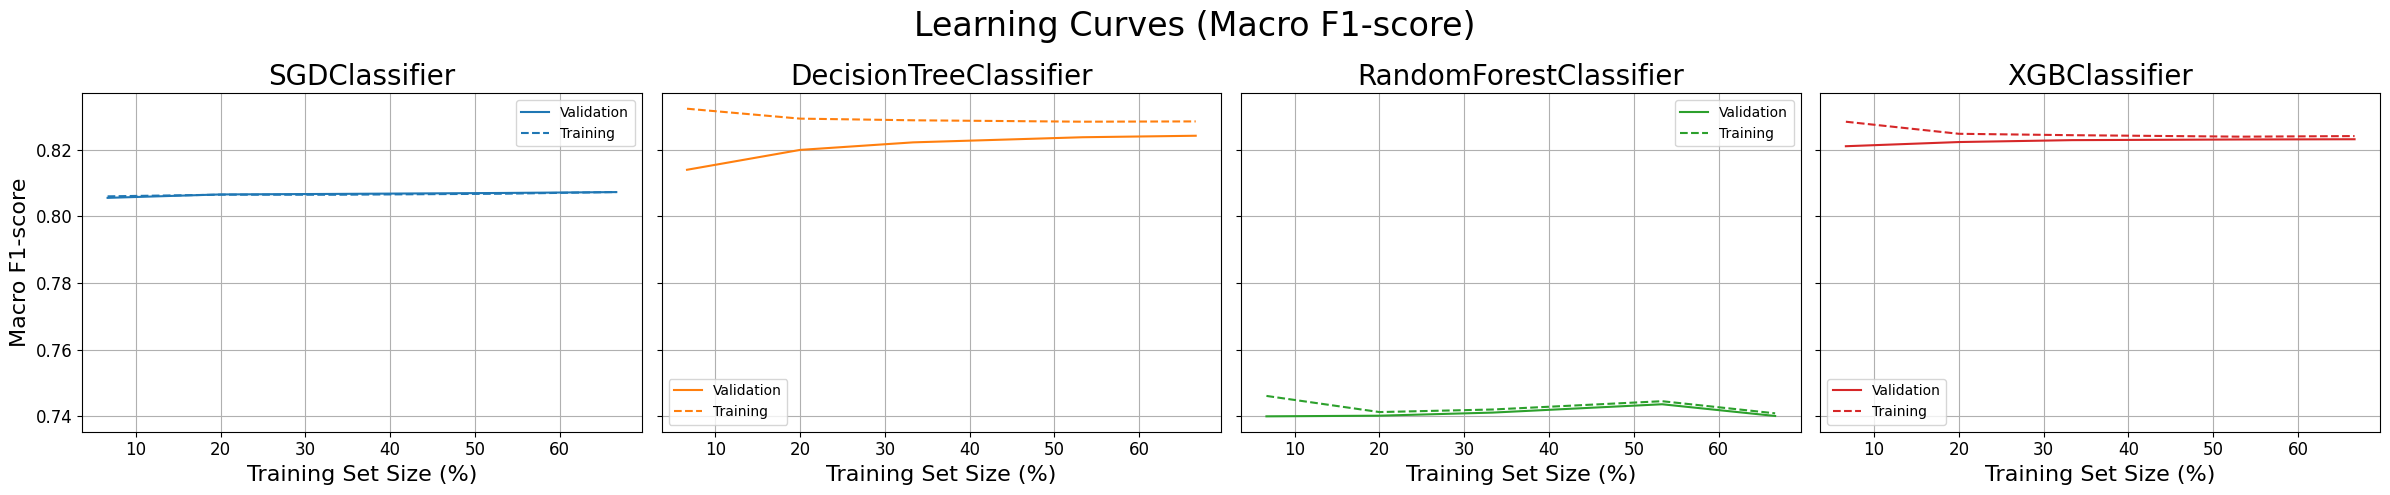

In [84]:
# Fit using Google Colab - takes a long time to calculate
# plot_learning_curves(models, X_train, y_train, save_path = 'learning_curves.pkl')

# Loading saved figure from pickle
fig = load_pickle('models/learning_curves.pkl')
save_figure_to_png(fig, 'visualizations/learning_curves.png')

Viewing the overall classification scores, the Decision Tree and the XGBoost both performed very similarly. Although the Decision Tree had slightly better Macro F1, Precision and Accuracy compared to the XGBoost, the stats between the two models are nearly identical. Going strictly off of the main metric we have chosen for scoring (Macro F1), the Decision Tree is the winner, but the XGBoost model was faster to train and thus is likely more scalable for practically identical performance. Either of these two models seem appropriate.

The Random Forest performed the worst overall with a particularly low Macro Recall score. It also was the worst performing model in terms of fit time, meaning it is not likely to be scalable. The Logistic Regression performed slightly worse than the Decision Tree and XGBoost, but it had a much worse fit time than those models. For both of those reasons, Logistic Regression is not preferred.

All of the models significantly outperformed a baseline classifier that simply predicted randomly according to class probabilities.

In [85]:
generate_classification_report_table(models, X_test, y_test)

Next, it is worthwhile to check for overfitting or underfitting in the models. There appears to be effectively no evidence of overfitting in the models, as the training and testing scores are nearly identical across metrics. Given the strength of the features that were crafted during the data preparation process, it would be hard to say that any of the models are underfitting except for perhaps the Random Forest.

Perhaps greater feature selection or engineering would produce better results, or maybe even more complex hyperparameter tuning, but generally speaking, macro scores in the 80-85%+ range would indicate that the models are performing very well in the face of large class imbalances (NYPD makes up 46% of the data, HPD makes up 21% of the data, and the next highest class representation is the DSNY at 9% of the data). Considering the extremely poor performance of a baseline model that randomly predicts according to class probabilities, it seems safe to say that the models are not underfitting.

In [86]:
training_vs_testing_metrics(models, X_train, y_train, X_test, y_test)

The next step is to identify class-by-class performance to see where each model struggled.

In [87]:
precisions, recalls, f1s = generate_per_class_separate_tables(models, X_test, y_test, label_encoder)

The Random Forest had the best overall performance with regards to precision. Notably, the Random Forest performed particularly well on the lower frequency classes of DHS, DOHMH, and Other. However, the Random Forest also struggled with precision on the most common classes of NYPD and HPD, at least in comparison to the other classifiers, which means the Random Forest was overconfident about the high frequency classes. The XGBoost model has the highest precision on the NYPD, meaning it is the most likely to not misdirect calls to the NYPD and waste valuable police resources.

All of the other classifiers performed relatively similarly across classes. The DOB and DPR were the hardest classes to predict precisely.

In [88]:
precisions

The Random Forest clearly favors the majority classes, achieving nearly perfect recall on both NYPD and HPD. The XGBoost model has the best overall recall and performed quite a bit better on the DHS category than the other models. Interestingly, the Logistic Regression outperforms the Decision Tree in a number of classes (DOB, DPR, and DSNY).

All of the classes, besides the Random Forest, performed fairly similarly across classes. The hardest classes to attain high recall on were DOT, Other, and DHS. Fortunately, all of the models had fairly high recall on the majority classes of the HPD and NYPD, as it is important for the most common agencies to actually receive calls that should be directed to them.

In [89]:
recalls

When looking at the F1 scores, it becomes immediately obvious that the Decision Tree and the XGBoost model are extremely close. The Random Forest has frankly terrible scores in comparison, and the Logistic Regression lags behind the Decision Tree and the XGBoost model. The XGBoost model has the slight advantage in F1 score for the rarest class (DHS), but the Decision Tree outperforms in far more classes. However, the difference between the two is so slight that they are functionally the same.

In [90]:
f1s

Overall, either the Decision Tree or the XGBoost model would be suitable choices for directing 311 calls to various NY agencies. Their performance is very similar across the board. The Decision Tree is useful in that it is more interpretable. The decision tree itself can be generated and shown to analyze all of the steps that make up its decision making process. The XGBoost model has the benefit of being able to utilize GPUs while training, making it more likely to scale as the size of the data grows, since it can leverage more powerful hardware to gain performance over the normal sci-kit learn models. The XGBoost model is also lower variance than the Decision Tree, making it a bit more reliable.

As the full size of the 311 dataset is very large and only continues to grow over time, the computational efficiency of the XGBoost model is likely more important than the interpretability of the Decision Tree model.